In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : ['coords'],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_e_0_0_coords_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(772408, 831)
(772408, 8)
validation
(101248, 831)
(101248, 8)
test
(98888, 831)
(98888, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 831)]             0         


 dense (Dense)               (None, 1024)              851968    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1542024 (5.88 MB)


Trainable params: 1542024 (5.88 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/78 [..............................] - ETA: 1:39 - loss: 2.1107 - STD: 0.1024 - MAE: 0.2145

 4/78 [>.............................] - ETA: 1s - loss: 1.6563 - STD: 0.1333 - MAE: 0.1796  

 8/78 [==>...........................] - ETA: 1s - loss: 1.4969 - STD: 0.1703 - MAE: 0.1598

 9/78 [==>...........................] - ETA: 5s - loss: 1.4916 - STD: 0.1732 - MAE: 0.1579

13/78 [====>.........................] - ETA: 4s - loss: 1.4398 - STD: 0.1776 - MAE: 0.1546

17/78 [=====>........................] - ETA: 3s - loss: 1.4143 - STD: 0.1820 - MAE: 0.1521

21/78 [=======>......................] - ETA: 2s - loss: 1.3978 - STD: 0.1862 - MAE: 0.1499

25/78 [========>.....................] - ETA: 2s - loss: 1.3857 - STD: 0.1875 - MAE: 0.1490

29/78 [==========>...................] - ETA: 1s - loss: 1.3758 - STD: 0.1883 - MAE: 0.1483

33/78 [===========>..................] - ETA: 1s - loss: 1.3696 - STD: 0.1895 - MAE: 0.1476

37/78 [=============>................] - ETA: 1s - loss: 1.3644 - STD: 0.1901 - MAE: 0.1473

41/78 [==============>...............] - ETA: 1s - loss: 1.3594 - STD: 0.1902 - MAE: 0.1471

45/78 [================>.............] - ETA: 0s - loss: 1.3553 - STD: 0.1904 - MAE: 0.1469

49/78 [=================>............] - ETA: 0s - loss: 1.3524 - STD: 0.1904 - MAE: 0.1469

53/78 [===================>..........] - ETA: 0s - loss: 1.3493 - STD: 0.1902 - MAE: 0.1468

57/78 [====================>.........] - ETA: 0s - loss: 1.3469 - STD: 0.1903 - MAE: 0.1467

61/78 [======================>.......] - ETA: 0s - loss: 1.3450 - STD: 0.1904 - MAE: 0.1467

65/78 [========================>.....] - ETA: 0s - loss: 1.3433 - STD: 0.1903 - MAE: 0.1466

68/78 [=========================>....] - ETA: 0s - loss: 1.3418 - STD: 0.1904 - MAE: 0.1465

72/78 [==========================>...] - ETA: 0s - loss: 1.3403 - STD: 0.1906 - MAE: 0.1464

76/78 [============================>.] - ETA: 0s - loss: 1.3395 - STD: 0.1905 - MAE: 0.1464

78/78 [==============================] - 4s 32ms/step - loss: 1.3389 - STD: 0.1905 - MAE: 0.1464 - val_loss: 1.2716 - val_STD: 0.1912 - val_MAE: 0.1450


Epoch 2/10000


 1/78 [..............................] - ETA: 3s - loss: 1.3065 - STD: 0.1912 - MAE: 0.1447

 5/78 [>.............................] - ETA: 1s - loss: 1.3081 - STD: 0.1944 - MAE: 0.1436

 9/78 [==>...........................] - ETA: 1s - loss: 1.3091 - STD: 0.1935 - MAE: 0.1441

13/78 [====>.........................] - ETA: 0s - loss: 1.3101 - STD: 0.1926 - MAE: 0.1445

17/78 [=====>........................] - ETA: 0s - loss: 1.3114 - STD: 0.1921 - MAE: 0.1448

21/78 [=======>......................] - ETA: 0s - loss: 1.3122 - STD: 0.1917 - MAE: 0.1450

25/78 [========>.....................] - ETA: 0s - loss: 1.3090 - STD: 0.1918 - MAE: 0.1447

29/78 [==========>...................] - ETA: 0s - loss: 1.3072 - STD: 0.1918 - MAE: 0.1447

33/78 [===========>..................] - ETA: 0s - loss: 1.3049 - STD: 0.1918 - MAE: 0.1445

37/78 [=============>................] - ETA: 0s - loss: 1.3020 - STD: 0.1917 - MAE: 0.1444

41/78 [==============>...............] - ETA: 0s - loss: 1.3001 - STD: 0.1920 - MAE: 0.1442

45/78 [================>.............] - ETA: 0s - loss: 1.2977 - STD: 0.1924 - MAE: 0.1438

49/78 [=================>............] - ETA: 0s - loss: 1.2946 - STD: 0.1929 - MAE: 0.1435

53/78 [===================>..........] - ETA: 0s - loss: 1.2922 - STD: 0.1928 - MAE: 0.1434

57/78 [====================>.........] - ETA: 0s - loss: 1.2890 - STD: 0.1932 - MAE: 0.1431

61/78 [======================>.......] - ETA: 0s - loss: 1.2857 - STD: 0.1939 - MAE: 0.1426

65/78 [========================>.....] - ETA: 0s - loss: 1.2825 - STD: 0.1942 - MAE: 0.1424

69/78 [=========================>....] - ETA: 0s - loss: 1.2796 - STD: 0.1946 - MAE: 0.1421

73/78 [===========================>..] - ETA: 0s - loss: 1.2774 - STD: 0.1948 - MAE: 0.1419

77/78 [============================>.] - ETA: 0s - loss: 1.2748 - STD: 0.1951 - MAE: 0.1417

78/78 [==============================] - 1s 18ms/step - loss: 1.2742 - STD: 0.1952 - MAE: 0.1417 - val_loss: 1.1653 - val_STD: 0.1840 - val_MAE: 0.1409


Epoch 3/10000


 1/78 [..............................] - ETA: 3s - loss: 1.2120 - STD: 0.1994 - MAE: 0.1377

 5/78 [>.............................] - ETA: 1s - loss: 1.2186 - STD: 0.1994 - MAE: 0.1378

 9/78 [==>...........................] - ETA: 1s - loss: 1.2174 - STD: 0.2006 - MAE: 0.1374

13/78 [====>.........................] - ETA: 1s - loss: 1.2115 - STD: 0.2011 - MAE: 0.1370

17/78 [=====>........................] - ETA: 0s - loss: 1.2076 - STD: 0.2014 - MAE: 0.1367

21/78 [=======>......................] - ETA: 0s - loss: 1.2036 - STD: 0.2016 - MAE: 0.1364

25/78 [========>.....................] - ETA: 0s - loss: 1.2023 - STD: 0.2015 - MAE: 0.1364

29/78 [==========>...................] - ETA: 0s - loss: 1.1987 - STD: 0.2020 - MAE: 0.1361

33/78 [===========>..................] - ETA: 0s - loss: 1.1974 - STD: 0.2020 - MAE: 0.1361

37/78 [=============>................] - ETA: 0s - loss: 1.1946 - STD: 0.2018 - MAE: 0.1361

41/78 [==============>...............] - ETA: 0s - loss: 1.1900 - STD: 0.2018 - MAE: 0.1359

45/78 [================>.............] - ETA: 0s - loss: 1.1855 - STD: 0.2022 - MAE: 0.1356

49/78 [=================>............] - ETA: 0s - loss: 1.1808 - STD: 0.2024 - MAE: 0.1353

53/78 [===================>..........] - ETA: 0s - loss: 1.1762 - STD: 0.2028 - MAE: 0.1350

57/78 [====================>.........] - ETA: 0s - loss: 1.1718 - STD: 0.2031 - MAE: 0.1347

61/78 [======================>.......] - ETA: 0s - loss: 1.1670 - STD: 0.2034 - MAE: 0.1344

65/78 [========================>.....] - ETA: 0s - loss: 1.1625 - STD: 0.2038 - MAE: 0.1340

69/78 [=========================>....] - ETA: 0s - loss: 1.1585 - STD: 0.2043 - MAE: 0.1337

73/78 [===========================>..] - ETA: 0s - loss: 1.1558 - STD: 0.2046 - MAE: 0.1335

77/78 [============================>.] - ETA: 0s - loss: 1.1528 - STD: 0.2049 - MAE: 0.1332

78/78 [==============================] - 1s 18ms/step - loss: 1.1518 - STD: 0.2050 - MAE: 0.1332 - val_loss: 1.0637 - val_STD: 0.1852 - val_MAE: 0.1368


Epoch 4/10000


 1/78 [..............................] - ETA: 3s - loss: 1.0876 - STD: 0.2027 - MAE: 0.1312

 5/78 [>.............................] - ETA: 1s - loss: 1.0710 - STD: 0.2119 - MAE: 0.1272

 9/78 [==>...........................] - ETA: 1s - loss: 1.0757 - STD: 0.2125 - MAE: 0.1273

13/78 [====>.........................] - ETA: 0s - loss: 1.0729 - STD: 0.2122 - MAE: 0.1274

17/78 [=====>........................] - ETA: 0s - loss: 1.0689 - STD: 0.2124 - MAE: 0.1272

21/78 [=======>......................] - ETA: 0s - loss: 1.0671 - STD: 0.2126 - MAE: 0.1271

25/78 [========>.....................] - ETA: 0s - loss: 1.0660 - STD: 0.2128 - MAE: 0.1270

29/78 [==========>...................] - ETA: 0s - loss: 1.0637 - STD: 0.2127 - MAE: 0.1270

33/78 [===========>..................] - ETA: 0s - loss: 1.0631 - STD: 0.2129 - MAE: 0.1270

37/78 [=============>................] - ETA: 0s - loss: 1.0610 - STD: 0.2127 - MAE: 0.1270

41/78 [==============>...............] - ETA: 0s - loss: 1.0591 - STD: 0.2126 - MAE: 0.1270

45/78 [================>.............] - ETA: 0s - loss: 1.0564 - STD: 0.2128 - MAE: 0.1268

49/78 [=================>............] - ETA: 0s - loss: 1.0539 - STD: 0.2131 - MAE: 0.1266

53/78 [===================>..........] - ETA: 0s - loss: 1.0517 - STD: 0.2132 - MAE: 0.1265

57/78 [====================>.........] - ETA: 0s - loss: 1.0489 - STD: 0.2134 - MAE: 0.1264

61/78 [======================>.......] - ETA: 0s - loss: 1.0464 - STD: 0.2133 - MAE: 0.1263

65/78 [========================>.....] - ETA: 0s - loss: 1.0437 - STD: 0.2134 - MAE: 0.1262

69/78 [=========================>....] - ETA: 0s - loss: 1.0409 - STD: 0.2136 - MAE: 0.1260

73/78 [===========================>..] - ETA: 0s - loss: 1.0382 - STD: 0.2138 - MAE: 0.1259

77/78 [============================>.] - ETA: 0s - loss: 1.0354 - STD: 0.2139 - MAE: 0.1258

78/78 [==============================] - 1s 18ms/step - loss: 1.0346 - STD: 0.2139 - MAE: 0.1257 - val_loss: 0.9389 - val_STD: 0.2031 - val_MAE: 0.1258


Epoch 5/10000


 1/78 [..............................] - ETA: 3s - loss: 0.9658 - STD: 0.2180 - MAE: 0.1214

 5/78 [>.............................] - ETA: 1s - loss: 0.9711 - STD: 0.2187 - MAE: 0.1215

 9/78 [==>...........................] - ETA: 1s - loss: 0.9707 - STD: 0.2175 - MAE: 0.1220

13/78 [====>.........................] - ETA: 1s - loss: 0.9649 - STD: 0.2181 - MAE: 0.1215

17/78 [=====>........................] - ETA: 0s - loss: 0.9625 - STD: 0.2185 - MAE: 0.1212

21/78 [=======>......................] - ETA: 0s - loss: 0.9634 - STD: 0.2190 - MAE: 0.1209

25/78 [========>.....................] - ETA: 0s - loss: 0.9627 - STD: 0.2195 - MAE: 0.1206

29/78 [==========>...................] - ETA: 0s - loss: 0.9617 - STD: 0.2200 - MAE: 0.1204

33/78 [===========>..................] - ETA: 0s - loss: 0.9610 - STD: 0.2202 - MAE: 0.1203

37/78 [=============>................] - ETA: 0s - loss: 0.9596 - STD: 0.2203 - MAE: 0.1202

41/78 [==============>...............] - ETA: 0s - loss: 0.9574 - STD: 0.2204 - MAE: 0.1200

45/78 [================>.............] - ETA: 0s - loss: 0.9554 - STD: 0.2206 - MAE: 0.1199

49/78 [=================>............] - ETA: 0s - loss: 0.9531 - STD: 0.2208 - MAE: 0.1197

53/78 [===================>..........] - ETA: 0s - loss: 0.9512 - STD: 0.2209 - MAE: 0.1196

57/78 [====================>.........] - ETA: 0s - loss: 0.9491 - STD: 0.2212 - MAE: 0.1194

62/78 [======================>.......] - ETA: 0s - loss: 0.9473 - STD: 0.2215 - MAE: 0.1191

66/78 [========================>.....] - ETA: 0s - loss: 0.9460 - STD: 0.2216 - MAE: 0.1190

70/78 [=========================>....] - ETA: 0s - loss: 0.9451 - STD: 0.2217 - MAE: 0.1190

74/78 [===========================>..] - ETA: 0s - loss: 0.9442 - STD: 0.2218 - MAE: 0.1189

78/78 [==============================] - ETA: 0s - loss: 0.9432 - STD: 0.2219 - MAE: 0.1188

78/78 [==============================] - 1s 18ms/step - loss: 0.9432 - STD: 0.2219 - MAE: 0.1188 - val_loss: 0.9320 - val_STD: 0.2152 - val_MAE: 0.1202


Epoch 6/10000


 1/78 [..............................] - ETA: 3s - loss: 0.9199 - STD: 0.2300 - MAE: 0.1145

 5/78 [>.............................] - ETA: 1s - loss: 0.9195 - STD: 0.2257 - MAE: 0.1163

 9/78 [==>...........................] - ETA: 1s - loss: 0.9209 - STD: 0.2255 - MAE: 0.1164

13/78 [====>.........................] - ETA: 1s - loss: 0.9208 - STD: 0.2251 - MAE: 0.1166

17/78 [=====>........................] - ETA: 0s - loss: 0.9220 - STD: 0.2247 - MAE: 0.1169

21/78 [=======>......................] - ETA: 0s - loss: 0.9215 - STD: 0.2248 - MAE: 0.1168

25/78 [========>.....................] - ETA: 0s - loss: 0.9180 - STD: 0.2249 - MAE: 0.1165

29/78 [==========>...................] - ETA: 0s - loss: 0.9168 - STD: 0.2249 - MAE: 0.1165

33/78 [===========>..................] - ETA: 0s - loss: 0.9160 - STD: 0.2251 - MAE: 0.1164

37/78 [=============>................] - ETA: 0s - loss: 0.9159 - STD: 0.2252 - MAE: 0.1164

41/78 [==============>...............] - ETA: 0s - loss: 0.9156 - STD: 0.2251 - MAE: 0.1164

45/78 [================>.............] - ETA: 0s - loss: 0.9142 - STD: 0.2253 - MAE: 0.1162

49/78 [=================>............] - ETA: 0s - loss: 0.9139 - STD: 0.2254 - MAE: 0.1162

53/78 [===================>..........] - ETA: 0s - loss: 0.9140 - STD: 0.2254 - MAE: 0.1162

57/78 [====================>.........] - ETA: 0s - loss: 0.9124 - STD: 0.2254 - MAE: 0.1161

61/78 [======================>.......] - ETA: 0s - loss: 0.9106 - STD: 0.2255 - MAE: 0.1160

65/78 [========================>.....] - ETA: 0s - loss: 0.9099 - STD: 0.2256 - MAE: 0.1159

69/78 [=========================>....] - ETA: 0s - loss: 0.9087 - STD: 0.2257 - MAE: 0.1158

73/78 [===========================>..] - ETA: 0s - loss: 0.9082 - STD: 0.2258 - MAE: 0.1157

77/78 [============================>.] - ETA: 0s - loss: 0.9076 - STD: 0.2258 - MAE: 0.1157

78/78 [==============================] - 1s 18ms/step - loss: 0.9072 - STD: 0.2258 - MAE: 0.1157 - val_loss: 0.8847 - val_STD: 0.2147 - val_MAE: 0.1194


Epoch 7/10000


 1/78 [..............................] - ETA: 3s - loss: 0.8891 - STD: 0.2280 - MAE: 0.1137

 5/78 [>.............................] - ETA: 1s - loss: 0.8894 - STD: 0.2273 - MAE: 0.1142

 9/78 [==>...........................] - ETA: 1s - loss: 0.8846 - STD: 0.2282 - MAE: 0.1135

13/78 [====>.........................] - ETA: 1s - loss: 0.8843 - STD: 0.2275 - MAE: 0.1139

17/78 [=====>........................] - ETA: 0s - loss: 0.8915 - STD: 0.2271 - MAE: 0.1144

21/78 [=======>......................] - ETA: 0s - loss: 0.8928 - STD: 0.2274 - MAE: 0.1143

25/78 [========>.....................] - ETA: 0s - loss: 0.8931 - STD: 0.2274 - MAE: 0.1144

29/78 [==========>...................] - ETA: 0s - loss: 0.8930 - STD: 0.2276 - MAE: 0.1143

33/78 [===========>..................] - ETA: 0s - loss: 0.8924 - STD: 0.2276 - MAE: 0.1142

37/78 [=============>................] - ETA: 0s - loss: 0.8927 - STD: 0.2277 - MAE: 0.1142

41/78 [==============>...............] - ETA: 0s - loss: 0.8918 - STD: 0.2278 - MAE: 0.1142

45/78 [================>.............] - ETA: 0s - loss: 0.8909 - STD: 0.2278 - MAE: 0.1141

49/78 [=================>............] - ETA: 0s - loss: 0.8901 - STD: 0.2278 - MAE: 0.1141

53/78 [===================>..........] - ETA: 0s - loss: 0.8895 - STD: 0.2279 - MAE: 0.1140

57/78 [====================>.........] - ETA: 0s - loss: 0.8882 - STD: 0.2279 - MAE: 0.1139

61/78 [======================>.......] - ETA: 0s - loss: 0.8871 - STD: 0.2280 - MAE: 0.1138

65/78 [========================>.....] - ETA: 0s - loss: 0.8861 - STD: 0.2282 - MAE: 0.1137

69/78 [=========================>....] - ETA: 0s - loss: 0.8858 - STD: 0.2283 - MAE: 0.1137

73/78 [===========================>..] - ETA: 0s - loss: 0.8858 - STD: 0.2283 - MAE: 0.1137

77/78 [============================>.] - ETA: 0s - loss: 0.8853 - STD: 0.2283 - MAE: 0.1137

78/78 [==============================] - 1s 18ms/step - loss: 0.8851 - STD: 0.2283 - MAE: 0.1137 - val_loss: 0.8779 - val_STD: 0.2284 - val_MAE: 0.1130


Epoch 8/10000


 1/78 [..............................] - ETA: 3s - loss: 0.8671 - STD: 0.2414 - MAE: 0.1067

 5/78 [>.............................] - ETA: 0s - loss: 0.8761 - STD: 0.2311 - MAE: 0.1122

 9/78 [==>...........................] - ETA: 0s - loss: 0.8758 - STD: 0.2304 - MAE: 0.1123

13/78 [====>.........................] - ETA: 0s - loss: 0.8730 - STD: 0.2299 - MAE: 0.1124

17/78 [=====>........................] - ETA: 0s - loss: 0.8737 - STD: 0.2296 - MAE: 0.1126

21/78 [=======>......................] - ETA: 0s - loss: 0.8740 - STD: 0.2296 - MAE: 0.1126

24/78 [========>.....................] - ETA: 0s - loss: 0.8739 - STD: 0.2295 - MAE: 0.1127

28/78 [=========>....................] - ETA: 0s - loss: 0.8726 - STD: 0.2296 - MAE: 0.1126

32/78 [===========>..................] - ETA: 0s - loss: 0.8723 - STD: 0.2296 - MAE: 0.1125

36/78 [============>.................] - ETA: 0s - loss: 0.8723 - STD: 0.2295 - MAE: 0.1126

40/78 [==============>...............] - ETA: 0s - loss: 0.8723 - STD: 0.2295 - MAE: 0.1127

44/78 [===============>..............] - ETA: 0s - loss: 0.8704 - STD: 0.2298 - MAE: 0.1124

48/78 [=================>............] - ETA: 0s - loss: 0.8697 - STD: 0.2299 - MAE: 0.1124

52/78 [===================>..........] - ETA: 0s - loss: 0.8698 - STD: 0.2299 - MAE: 0.1123

56/78 [====================>.........] - ETA: 0s - loss: 0.8692 - STD: 0.2300 - MAE: 0.1123

60/78 [======================>.......] - ETA: 0s - loss: 0.8689 - STD: 0.2300 - MAE: 0.1123

64/78 [=======================>......] - ETA: 0s - loss: 0.8683 - STD: 0.2300 - MAE: 0.1122

68/78 [=========================>....] - ETA: 0s - loss: 0.8674 - STD: 0.2301 - MAE: 0.1121

72/78 [==========================>...] - ETA: 0s - loss: 0.8669 - STD: 0.2302 - MAE: 0.1121

76/78 [============================>.] - ETA: 0s - loss: 0.8667 - STD: 0.2302 - MAE: 0.1120

78/78 [==============================] - 1s 18ms/step - loss: 0.8665 - STD: 0.2302 - MAE: 0.1121 - val_loss: 0.8600 - val_STD: 0.2235 - val_MAE: 0.1147


Epoch 9/10000


 1/78 [..............................] - ETA: 3s - loss: 0.8610 - STD: 0.2345 - MAE: 0.1100

 4/78 [>.............................] - ETA: 1s - loss: 0.8591 - STD: 0.2301 - MAE: 0.1119

 8/78 [==>...........................] - ETA: 1s - loss: 0.8601 - STD: 0.2308 - MAE: 0.1116

12/78 [===>..........................] - ETA: 1s - loss: 0.8577 - STD: 0.2307 - MAE: 0.1115

16/78 [=====>........................] - ETA: 0s - loss: 0.8561 - STD: 0.2309 - MAE: 0.1113

20/78 [======>.......................] - ETA: 0s - loss: 0.8556 - STD: 0.2310 - MAE: 0.1113

24/78 [========>.....................] - ETA: 0s - loss: 0.8538 - STD: 0.2312 - MAE: 0.1111

28/78 [=========>....................] - ETA: 0s - loss: 0.8540 - STD: 0.2314 - MAE: 0.1110

32/78 [===========>..................] - ETA: 0s - loss: 0.8543 - STD: 0.2314 - MAE: 0.1110

36/78 [============>.................] - ETA: 0s - loss: 0.8542 - STD: 0.2313 - MAE: 0.1111

40/78 [==============>...............] - ETA: 0s - loss: 0.8528 - STD: 0.2314 - MAE: 0.1110

44/78 [===============>..............] - ETA: 0s - loss: 0.8521 - STD: 0.2314 - MAE: 0.1109

48/78 [=================>............] - ETA: 0s - loss: 0.8518 - STD: 0.2315 - MAE: 0.1108

52/78 [===================>..........] - ETA: 0s - loss: 0.8519 - STD: 0.2315 - MAE: 0.1109

56/78 [====================>.........] - ETA: 0s - loss: 0.8512 - STD: 0.2316 - MAE: 0.1108

60/78 [======================>.......] - ETA: 0s - loss: 0.8510 - STD: 0.2316 - MAE: 0.1108

64/78 [=======================>......] - ETA: 0s - loss: 0.8505 - STD: 0.2317 - MAE: 0.1107

68/78 [=========================>....] - ETA: 0s - loss: 0.8512 - STD: 0.2316 - MAE: 0.1108

72/78 [==========================>...] - ETA: 0s - loss: 0.8505 - STD: 0.2316 - MAE: 0.1108

76/78 [============================>.] - ETA: 0s - loss: 0.8495 - STD: 0.2317 - MAE: 0.1107

78/78 [==============================] - 1s 18ms/step - loss: 0.8494 - STD: 0.2317 - MAE: 0.1107 - val_loss: 0.8347 - val_STD: 0.2249 - val_MAE: 0.1136


Epoch 10/10000


 1/78 [..............................] - ETA: 3s - loss: 0.8332 - STD: 0.2344 - MAE: 0.1090

 5/78 [>.............................] - ETA: 1s - loss: 0.8345 - STD: 0.2333 - MAE: 0.1093

 9/78 [==>...........................] - ETA: 1s - loss: 0.8359 - STD: 0.2332 - MAE: 0.1094

13/78 [====>.........................] - ETA: 0s - loss: 0.8459 - STD: 0.2331 - MAE: 0.1099

17/78 [=====>........................] - ETA: 0s - loss: 0.8420 - STD: 0.2333 - MAE: 0.1096

21/78 [=======>......................] - ETA: 0s - loss: 0.8418 - STD: 0.2333 - MAE: 0.1096

25/78 [========>.....................] - ETA: 0s - loss: 0.8423 - STD: 0.2330 - MAE: 0.1098

29/78 [==========>...................] - ETA: 0s - loss: 0.8428 - STD: 0.2331 - MAE: 0.1098

33/78 [===========>..................] - ETA: 0s - loss: 0.8435 - STD: 0.2329 - MAE: 0.1099

37/78 [=============>................] - ETA: 0s - loss: 0.8438 - STD: 0.2329 - MAE: 0.1099

41/78 [==============>...............] - ETA: 0s - loss: 0.8423 - STD: 0.2329 - MAE: 0.1098

45/78 [================>.............] - ETA: 0s - loss: 0.8422 - STD: 0.2330 - MAE: 0.1098

49/78 [=================>............] - ETA: 0s - loss: 0.8420 - STD: 0.2329 - MAE: 0.1098

53/78 [===================>..........] - ETA: 0s - loss: 0.8420 - STD: 0.2329 - MAE: 0.1098

57/78 [====================>.........] - ETA: 0s - loss: 0.8422 - STD: 0.2329 - MAE: 0.1098

61/78 [======================>.......] - ETA: 0s - loss: 0.8423 - STD: 0.2329 - MAE: 0.1098

65/78 [========================>.....] - ETA: 0s - loss: 0.8425 - STD: 0.2329 - MAE: 0.1098

69/78 [=========================>....] - ETA: 0s - loss: 0.8420 - STD: 0.2330 - MAE: 0.1098

74/78 [===========================>..] - ETA: 0s - loss: 0.8419 - STD: 0.2331 - MAE: 0.1097

78/78 [==============================] - ETA: 0s - loss: 0.8420 - STD: 0.2331 - MAE: 0.1097

78/78 [==============================] - 1s 18ms/step - loss: 0.8420 - STD: 0.2331 - MAE: 0.1097 - val_loss: 0.8177 - val_STD: 0.2193 - val_MAE: 0.1161


Epoch 11/10000


 1/78 [..............................] - ETA: 3s - loss: 0.8239 - STD: 0.2280 - MAE: 0.1112

 5/78 [>.............................] - ETA: 1s - loss: 0.8323 - STD: 0.2321 - MAE: 0.1096

 9/78 [==>...........................] - ETA: 1s - loss: 0.8333 - STD: 0.2326 - MAE: 0.1095

13/78 [====>.........................] - ETA: 0s - loss: 0.8314 - STD: 0.2332 - MAE: 0.1091

17/78 [=====>........................] - ETA: 0s - loss: 0.8317 - STD: 0.2332 - MAE: 0.1092

21/78 [=======>......................] - ETA: 0s - loss: 0.8297 - STD: 0.2336 - MAE: 0.1089

25/78 [========>.....................] - ETA: 0s - loss: 0.8301 - STD: 0.2335 - MAE: 0.1089

29/78 [==========>...................] - ETA: 0s - loss: 0.8299 - STD: 0.2335 - MAE: 0.1090

33/78 [===========>..................] - ETA: 0s - loss: 0.8293 - STD: 0.2336 - MAE: 0.1089

37/78 [=============>................] - ETA: 0s - loss: 0.8298 - STD: 0.2336 - MAE: 0.1090

41/78 [==============>...............] - ETA: 0s - loss: 0.8296 - STD: 0.2337 - MAE: 0.1089

45/78 [================>.............] - ETA: 0s - loss: 0.8300 - STD: 0.2336 - MAE: 0.1089

49/78 [=================>............] - ETA: 0s - loss: 0.8295 - STD: 0.2337 - MAE: 0.1089

53/78 [===================>..........] - ETA: 0s - loss: 0.8288 - STD: 0.2337 - MAE: 0.1088

57/78 [====================>.........] - ETA: 0s - loss: 0.8281 - STD: 0.2340 - MAE: 0.1087

61/78 [======================>.......] - ETA: 0s - loss: 0.8278 - STD: 0.2339 - MAE: 0.1087

65/78 [========================>.....] - ETA: 0s - loss: 0.8275 - STD: 0.2340 - MAE: 0.1087

69/78 [=========================>....] - ETA: 0s - loss: 0.8269 - STD: 0.2340 - MAE: 0.1086

73/78 [===========================>..] - ETA: 0s - loss: 0.8270 - STD: 0.2340 - MAE: 0.1086

77/78 [============================>.] - ETA: 0s - loss: 0.8270 - STD: 0.2341 - MAE: 0.1086

78/78 [==============================] - 1s 18ms/step - loss: 0.8270 - STD: 0.2341 - MAE: 0.1086 - val_loss: 0.7936 - val_STD: 0.2302 - val_MAE: 0.1096


Epoch 12/10000


 1/78 [..............................] - ETA: 3s - loss: 0.8230 - STD: 0.2383 - MAE: 0.1064

 5/78 [>.............................] - ETA: 1s - loss: 0.8189 - STD: 0.2364 - MAE: 0.1070

 9/78 [==>...........................] - ETA: 1s - loss: 0.8210 - STD: 0.2354 - MAE: 0.1076

13/78 [====>.........................] - ETA: 1s - loss: 0.8200 - STD: 0.2351 - MAE: 0.1077

17/78 [=====>........................] - ETA: 0s - loss: 0.8194 - STD: 0.2350 - MAE: 0.1077

21/78 [=======>......................] - ETA: 0s - loss: 0.8173 - STD: 0.2350 - MAE: 0.1076

25/78 [========>.....................] - ETA: 0s - loss: 0.8172 - STD: 0.2353 - MAE: 0.1075

29/78 [==========>...................] - ETA: 0s - loss: 0.8168 - STD: 0.2352 - MAE: 0.1075

33/78 [===========>..................] - ETA: 0s - loss: 0.8172 - STD: 0.2352 - MAE: 0.1076

37/78 [=============>................] - ETA: 0s - loss: 0.8184 - STD: 0.2351 - MAE: 0.1077

41/78 [==============>...............] - ETA: 0s - loss: 0.8188 - STD: 0.2351 - MAE: 0.1077

45/78 [================>.............] - ETA: 0s - loss: 0.8182 - STD: 0.2351 - MAE: 0.1077

49/78 [=================>............] - ETA: 0s - loss: 0.8177 - STD: 0.2352 - MAE: 0.1077

53/78 [===================>..........] - ETA: 0s - loss: 0.8179 - STD: 0.2351 - MAE: 0.1077

57/78 [====================>.........] - ETA: 0s - loss: 0.8177 - STD: 0.2352 - MAE: 0.1077

61/78 [======================>.......] - ETA: 0s - loss: 0.8172 - STD: 0.2352 - MAE: 0.1077

65/78 [========================>.....] - ETA: 0s - loss: 0.8171 - STD: 0.2352 - MAE: 0.1076

69/78 [=========================>....] - ETA: 0s - loss: 0.8170 - STD: 0.2351 - MAE: 0.1077

73/78 [===========================>..] - ETA: 0s - loss: 0.8167 - STD: 0.2352 - MAE: 0.1076

77/78 [============================>.] - ETA: 0s - loss: 0.8169 - STD: 0.2352 - MAE: 0.1076

78/78 [==============================] - 1s 18ms/step - loss: 0.8170 - STD: 0.2353 - MAE: 0.1076 - val_loss: 0.8809 - val_STD: 0.2204 - val_MAE: 0.1174


Epoch 13/10000


 1/78 [..............................] - ETA: 2s - loss: 0.8468 - STD: 0.2280 - MAE: 0.1116

 5/78 [>.............................] - ETA: 1s - loss: 0.8320 - STD: 0.2360 - MAE: 0.1076

 9/78 [==>...........................] - ETA: 1s - loss: 0.8289 - STD: 0.2350 - MAE: 0.1081

13/78 [====>.........................] - ETA: 0s - loss: 0.8244 - STD: 0.2350 - MAE: 0.1080

17/78 [=====>........................] - ETA: 0s - loss: 0.8212 - STD: 0.2355 - MAE: 0.1076

21/78 [=======>......................] - ETA: 0s - loss: 0.8208 - STD: 0.2355 - MAE: 0.1076

25/78 [========>.....................] - ETA: 0s - loss: 0.8192 - STD: 0.2355 - MAE: 0.1075

29/78 [==========>...................] - ETA: 0s - loss: 0.8169 - STD: 0.2356 - MAE: 0.1074

33/78 [===========>..................] - ETA: 0s - loss: 0.8175 - STD: 0.2356 - MAE: 0.1074

37/78 [=============>................] - ETA: 0s - loss: 0.8166 - STD: 0.2356 - MAE: 0.1074

41/78 [==============>...............] - ETA: 0s - loss: 0.8157 - STD: 0.2356 - MAE: 0.1073

45/78 [================>.............] - ETA: 0s - loss: 0.8145 - STD: 0.2356 - MAE: 0.1073

49/78 [=================>............] - ETA: 0s - loss: 0.8143 - STD: 0.2357 - MAE: 0.1072

53/78 [===================>..........] - ETA: 0s - loss: 0.8146 - STD: 0.2357 - MAE: 0.1072

57/78 [====================>.........] - ETA: 0s - loss: 0.8140 - STD: 0.2357 - MAE: 0.1072

61/78 [======================>.......] - ETA: 0s - loss: 0.8131 - STD: 0.2358 - MAE: 0.1071

65/78 [========================>.....] - ETA: 0s - loss: 0.8126 - STD: 0.2359 - MAE: 0.1071

69/78 [=========================>....] - ETA: 0s - loss: 0.8121 - STD: 0.2359 - MAE: 0.1070

73/78 [===========================>..] - ETA: 0s - loss: 0.8120 - STD: 0.2360 - MAE: 0.1070

77/78 [============================>.] - ETA: 0s - loss: 0.8128 - STD: 0.2358 - MAE: 0.1071

78/78 [==============================] - 1s 18ms/step - loss: 0.8130 - STD: 0.2360 - MAE: 0.1070 - val_loss: 0.8847 - val_STD: 0.2242 - val_MAE: 0.1158


Epoch 14/10000


 1/78 [..............................] - ETA: 4s - loss: 0.8450 - STD: 0.2320 - MAE: 0.1097

 5/78 [>.............................] - ETA: 1s - loss: 0.8231 - STD: 0.2359 - MAE: 0.1074

 9/78 [==>...........................] - ETA: 1s - loss: 0.8208 - STD: 0.2363 - MAE: 0.1072

13/78 [====>.........................] - ETA: 0s - loss: 0.8165 - STD: 0.2358 - MAE: 0.1072

17/78 [=====>........................] - ETA: 0s - loss: 0.8151 - STD: 0.2356 - MAE: 0.1073

21/78 [=======>......................] - ETA: 0s - loss: 0.8131 - STD: 0.2358 - MAE: 0.1071

25/78 [========>.....................] - ETA: 0s - loss: 0.8102 - STD: 0.2360 - MAE: 0.1069

29/78 [==========>...................] - ETA: 0s - loss: 0.8085 - STD: 0.2361 - MAE: 0.1067

33/78 [===========>..................] - ETA: 0s - loss: 0.8081 - STD: 0.2364 - MAE: 0.1066

37/78 [=============>................] - ETA: 0s - loss: 0.8069 - STD: 0.2363 - MAE: 0.1066

41/78 [==============>...............] - ETA: 0s - loss: 0.8060 - STD: 0.2363 - MAE: 0.1065

45/78 [================>.............] - ETA: 0s - loss: 0.8057 - STD: 0.2365 - MAE: 0.1064

49/78 [=================>............] - ETA: 0s - loss: 0.8050 - STD: 0.2364 - MAE: 0.1064

53/78 [===================>..........] - ETA: 0s - loss: 0.8047 - STD: 0.2364 - MAE: 0.1064

57/78 [====================>.........] - ETA: 0s - loss: 0.8046 - STD: 0.2365 - MAE: 0.1064

61/78 [======================>.......] - ETA: 0s - loss: 0.8038 - STD: 0.2365 - MAE: 0.1064

65/78 [========================>.....] - ETA: 0s - loss: 0.8036 - STD: 0.2365 - MAE: 0.1063

69/78 [=========================>....] - ETA: 0s - loss: 0.8029 - STD: 0.2366 - MAE: 0.1063

74/78 [===========================>..] - ETA: 0s - loss: 0.8024 - STD: 0.2367 - MAE: 0.1062

78/78 [==============================] - ETA: 0s - loss: 0.8020 - STD: 0.2367 - MAE: 0.1061

78/78 [==============================] - 1s 18ms/step - loss: 0.8020 - STD: 0.2367 - MAE: 0.1061 - val_loss: 0.7825 - val_STD: 0.2296 - val_MAE: 0.1097


Epoch 15/10000


 1/78 [..............................] - ETA: 4s - loss: 0.7880 - STD: 0.2370 - MAE: 0.1054

 5/78 [>.............................] - ETA: 1s - loss: 0.7939 - STD: 0.2378 - MAE: 0.1053

 8/78 [==>...........................] - ETA: 1s - loss: 0.7909 - STD: 0.2380 - MAE: 0.1051

12/78 [===>..........................] - ETA: 1s - loss: 0.7916 - STD: 0.2376 - MAE: 0.1053

16/78 [=====>........................] - ETA: 0s - loss: 0.7931 - STD: 0.2378 - MAE: 0.1053

20/78 [======>.......................] - ETA: 0s - loss: 0.7934 - STD: 0.2379 - MAE: 0.1052

24/78 [========>.....................] - ETA: 0s - loss: 0.7917 - STD: 0.2379 - MAE: 0.1051

28/78 [=========>....................] - ETA: 0s - loss: 0.7930 - STD: 0.2377 - MAE: 0.1052

32/78 [===========>..................] - ETA: 0s - loss: 0.7931 - STD: 0.2381 - MAE: 0.1050

36/78 [============>.................] - ETA: 0s - loss: 0.7951 - STD: 0.2380 - MAE: 0.1052

40/78 [==============>...............] - ETA: 0s - loss: 0.7960 - STD: 0.2381 - MAE: 0.1052

44/78 [===============>..............] - ETA: 0s - loss: 0.7990 - STD: 0.2380 - MAE: 0.1054

48/78 [=================>............] - ETA: 0s - loss: 0.8010 - STD: 0.2378 - MAE: 0.1056

52/78 [===================>..........] - ETA: 0s - loss: 0.8008 - STD: 0.2378 - MAE: 0.1056

56/78 [====================>.........] - ETA: 0s - loss: 0.8003 - STD: 0.2378 - MAE: 0.1056

60/78 [======================>.......] - ETA: 0s - loss: 0.8001 - STD: 0.2376 - MAE: 0.1057

64/78 [=======================>......] - ETA: 0s - loss: 0.7997 - STD: 0.2375 - MAE: 0.1057

68/78 [=========================>....] - ETA: 0s - loss: 0.7991 - STD: 0.2375 - MAE: 0.1056

72/78 [==========================>...] - ETA: 0s - loss: 0.7984 - STD: 0.2375 - MAE: 0.1056

77/78 [============================>.] - ETA: 0s - loss: 0.7976 - STD: 0.2376 - MAE: 0.1055

78/78 [==============================] - 1s 18ms/step - loss: 0.7974 - STD: 0.2375 - MAE: 0.1056 - val_loss: 0.7652 - val_STD: 0.2346 - val_MAE: 0.1068


Epoch 16/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7935 - STD: 0.2424 - MAE: 0.1029

 5/78 [>.............................] - ETA: 1s - loss: 0.7937 - STD: 0.2390 - MAE: 0.1045

 9/78 [==>...........................] - ETA: 1s - loss: 0.7983 - STD: 0.2393 - MAE: 0.1046

13/78 [====>.........................] - ETA: 0s - loss: 0.7972 - STD: 0.2385 - MAE: 0.1050

17/78 [=====>........................] - ETA: 0s - loss: 0.7965 - STD: 0.2383 - MAE: 0.1051

21/78 [=======>......................] - ETA: 0s - loss: 0.7939 - STD: 0.2382 - MAE: 0.1050

25/78 [========>.....................] - ETA: 0s - loss: 0.7927 - STD: 0.2383 - MAE: 0.1049

29/78 [==========>...................] - ETA: 0s - loss: 0.7920 - STD: 0.2382 - MAE: 0.1049

33/78 [===========>..................] - ETA: 0s - loss: 0.7917 - STD: 0.2383 - MAE: 0.1049

37/78 [=============>................] - ETA: 0s - loss: 0.7916 - STD: 0.2383 - MAE: 0.1049

41/78 [==============>...............] - ETA: 0s - loss: 0.7906 - STD: 0.2382 - MAE: 0.1049

45/78 [================>.............] - ETA: 0s - loss: 0.7898 - STD: 0.2382 - MAE: 0.1049

49/78 [=================>............] - ETA: 0s - loss: 0.7891 - STD: 0.2382 - MAE: 0.1049

53/78 [===================>..........] - ETA: 0s - loss: 0.7883 - STD: 0.2383 - MAE: 0.1048

57/78 [====================>.........] - ETA: 0s - loss: 0.7877 - STD: 0.2383 - MAE: 0.1047

61/78 [======================>.......] - ETA: 0s - loss: 0.7886 - STD: 0.2383 - MAE: 0.1047

66/78 [========================>.....] - ETA: 0s - loss: 0.7880 - STD: 0.2383 - MAE: 0.1047

70/78 [=========================>....] - ETA: 0s - loss: 0.7881 - STD: 0.2383 - MAE: 0.1047

74/78 [===========================>..] - ETA: 0s - loss: 0.7891 - STD: 0.2384 - MAE: 0.1047

78/78 [==============================] - ETA: 0s - loss: 0.7895 - STD: 0.2384 - MAE: 0.1047

78/78 [==============================] - 1s 17ms/step - loss: 0.7895 - STD: 0.2384 - MAE: 0.1047 - val_loss: 0.7502 - val_STD: 0.2363 - val_MAE: 0.1051


Epoch 17/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7826 - STD: 0.2430 - MAE: 0.1020

 4/78 [>.............................] - ETA: 1s - loss: 0.7872 - STD: 0.2388 - MAE: 0.1045

 8/78 [==>...........................] - ETA: 1s - loss: 0.7804 - STD: 0.2380 - MAE: 0.1045

12/78 [===>..........................] - ETA: 1s - loss: 0.7821 - STD: 0.2385 - MAE: 0.1044

16/78 [=====>........................] - ETA: 0s - loss: 0.7854 - STD: 0.2387 - MAE: 0.1044

20/78 [======>.......................] - ETA: 0s - loss: 0.7840 - STD: 0.2387 - MAE: 0.1043

24/78 [========>.....................] - ETA: 0s - loss: 0.7847 - STD: 0.2387 - MAE: 0.1043

28/78 [=========>....................] - ETA: 0s - loss: 0.7866 - STD: 0.2385 - MAE: 0.1045

32/78 [===========>..................] - ETA: 0s - loss: 0.7884 - STD: 0.2383 - MAE: 0.1047

36/78 [============>.................] - ETA: 0s - loss: 0.7874 - STD: 0.2383 - MAE: 0.1047

40/78 [==============>...............] - ETA: 0s - loss: 0.7870 - STD: 0.2384 - MAE: 0.1046

44/78 [===============>..............] - ETA: 0s - loss: 0.7881 - STD: 0.2385 - MAE: 0.1046

48/78 [=================>............] - ETA: 0s - loss: 0.7874 - STD: 0.2385 - MAE: 0.1046

52/78 [===================>..........] - ETA: 0s - loss: 0.7869 - STD: 0.2385 - MAE: 0.1045

56/78 [====================>.........] - ETA: 0s - loss: 0.7859 - STD: 0.2385 - MAE: 0.1045

60/78 [======================>.......] - ETA: 0s - loss: 0.7855 - STD: 0.2385 - MAE: 0.1045

64/78 [=======================>......] - ETA: 0s - loss: 0.7848 - STD: 0.2386 - MAE: 0.1044

68/78 [=========================>....] - ETA: 0s - loss: 0.7846 - STD: 0.2386 - MAE: 0.1044

72/78 [==========================>...] - ETA: 0s - loss: 0.7836 - STD: 0.2387 - MAE: 0.1043

76/78 [============================>.] - ETA: 0s - loss: 0.7827 - STD: 0.2387 - MAE: 0.1042

78/78 [==============================] - 1s 17ms/step - loss: 0.7826 - STD: 0.2388 - MAE: 0.1042 - val_loss: 0.7611 - val_STD: 0.2302 - val_MAE: 0.1087


Epoch 18/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7585 - STD: 0.2372 - MAE: 0.1036

 4/78 [>.............................] - ETA: 1s - loss: 0.7670 - STD: 0.2382 - MAE: 0.1037

 8/78 [==>...........................] - ETA: 1s - loss: 0.7688 - STD: 0.2384 - MAE: 0.1037

12/78 [===>..........................] - ETA: 1s - loss: 0.7721 - STD: 0.2387 - MAE: 0.1037

17/78 [=====>........................] - ETA: 0s - loss: 0.7751 - STD: 0.2394 - MAE: 0.1036

21/78 [=======>......................] - ETA: 0s - loss: 0.7748 - STD: 0.2396 - MAE: 0.1034

25/78 [========>.....................] - ETA: 0s - loss: 0.7796 - STD: 0.2395 - MAE: 0.1037

29/78 [==========>...................] - ETA: 0s - loss: 0.7803 - STD: 0.2393 - MAE: 0.1038

33/78 [===========>..................] - ETA: 0s - loss: 0.7803 - STD: 0.2394 - MAE: 0.1038

37/78 [=============>................] - ETA: 0s - loss: 0.7813 - STD: 0.2394 - MAE: 0.1038

41/78 [==============>...............] - ETA: 0s - loss: 0.7840 - STD: 0.2395 - MAE: 0.1039

45/78 [================>.............] - ETA: 0s - loss: 0.7858 - STD: 0.2393 - MAE: 0.1041

49/78 [=================>............] - ETA: 0s - loss: 0.7853 - STD: 0.2393 - MAE: 0.1041

53/78 [===================>..........] - ETA: 0s - loss: 0.7841 - STD: 0.2393 - MAE: 0.1040

57/78 [====================>.........] - ETA: 0s - loss: 0.7834 - STD: 0.2394 - MAE: 0.1039

61/78 [======================>.......] - ETA: 0s - loss: 0.7830 - STD: 0.2395 - MAE: 0.1039

65/78 [========================>.....] - ETA: 0s - loss: 0.7829 - STD: 0.2394 - MAE: 0.1039

69/78 [=========================>....] - ETA: 0s - loss: 0.7819 - STD: 0.2395 - MAE: 0.1038

73/78 [===========================>..] - ETA: 0s - loss: 0.7815 - STD: 0.2394 - MAE: 0.1038

77/78 [============================>.] - ETA: 0s - loss: 0.7810 - STD: 0.2394 - MAE: 0.1038

78/78 [==============================] - 1s 17ms/step - loss: 0.7810 - STD: 0.2393 - MAE: 0.1038 - val_loss: 0.7710 - val_STD: 0.2295 - val_MAE: 0.1097


Epoch 19/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7686 - STD: 0.2374 - MAE: 0.1040

 5/78 [>.............................] - ETA: 1s - loss: 0.7772 - STD: 0.2395 - MAE: 0.1035

 9/78 [==>...........................] - ETA: 1s - loss: 0.7781 - STD: 0.2403 - MAE: 0.1032

13/78 [====>.........................] - ETA: 0s - loss: 0.7752 - STD: 0.2401 - MAE: 0.1032

16/78 [=====>........................] - ETA: 0s - loss: 0.7719 - STD: 0.2399 - MAE: 0.1032

20/78 [======>.......................] - ETA: 0s - loss: 0.7696 - STD: 0.2400 - MAE: 0.1030

24/78 [========>.....................] - ETA: 0s - loss: 0.7699 - STD: 0.2401 - MAE: 0.1029

28/78 [=========>....................] - ETA: 0s - loss: 0.7696 - STD: 0.2400 - MAE: 0.1030

32/78 [===========>..................] - ETA: 0s - loss: 0.7694 - STD: 0.2398 - MAE: 0.1030

36/78 [============>.................] - ETA: 0s - loss: 0.7686 - STD: 0.2400 - MAE: 0.1029

40/78 [==============>...............] - ETA: 0s - loss: 0.7687 - STD: 0.2400 - MAE: 0.1029

44/78 [===============>..............] - ETA: 0s - loss: 0.7712 - STD: 0.2398 - MAE: 0.1031

48/78 [=================>............] - ETA: 0s - loss: 0.7729 - STD: 0.2402 - MAE: 0.1030

52/78 [===================>..........] - ETA: 0s - loss: 0.7745 - STD: 0.2401 - MAE: 0.1031

56/78 [====================>.........] - ETA: 0s - loss: 0.7746 - STD: 0.2401 - MAE: 0.1031

60/78 [======================>.......] - ETA: 0s - loss: 0.7748 - STD: 0.2402 - MAE: 0.1031

63/78 [=======================>......] - ETA: 0s - loss: 0.7745 - STD: 0.2401 - MAE: 0.1031

67/78 [========================>.....] - ETA: 0s - loss: 0.7743 - STD: 0.2400 - MAE: 0.1032

71/78 [==========================>...] - ETA: 0s - loss: 0.7744 - STD: 0.2401 - MAE: 0.1031

75/78 [===========================>..] - ETA: 0s - loss: 0.7739 - STD: 0.2401 - MAE: 0.1031

78/78 [==============================] - 1s 18ms/step - loss: 0.7734 - STD: 0.2401 - MAE: 0.1031 - val_loss: 0.7882 - val_STD: 0.2276 - val_MAE: 0.1112


Epoch 20/10000


 1/78 [..............................] - ETA: 4s - loss: 0.7774 - STD: 0.2360 - MAE: 0.1052

 4/78 [>.............................] - ETA: 1s - loss: 0.7700 - STD: 0.2392 - MAE: 0.1034

 8/78 [==>...........................] - ETA: 1s - loss: 0.7678 - STD: 0.2400 - MAE: 0.1028

12/78 [===>..........................] - ETA: 1s - loss: 0.7657 - STD: 0.2401 - MAE: 0.1027

16/78 [=====>........................] - ETA: 0s - loss: 0.7671 - STD: 0.2402 - MAE: 0.1027

20/78 [======>.......................] - ETA: 0s - loss: 0.7660 - STD: 0.2407 - MAE: 0.1024

24/78 [========>.....................] - ETA: 0s - loss: 0.7654 - STD: 0.2405 - MAE: 0.1025

28/78 [=========>....................] - ETA: 0s - loss: 0.7656 - STD: 0.2405 - MAE: 0.1025

32/78 [===========>..................] - ETA: 0s - loss: 0.7648 - STD: 0.2405 - MAE: 0.1024

36/78 [============>.................] - ETA: 0s - loss: 0.7655 - STD: 0.2404 - MAE: 0.1025

40/78 [==============>...............] - ETA: 0s - loss: 0.7661 - STD: 0.2406 - MAE: 0.1025

44/78 [===============>..............] - ETA: 0s - loss: 0.7662 - STD: 0.2405 - MAE: 0.1025

48/78 [=================>............] - ETA: 0s - loss: 0.7656 - STD: 0.2405 - MAE: 0.1025

52/78 [===================>..........] - ETA: 0s - loss: 0.7655 - STD: 0.2405 - MAE: 0.1025

56/78 [====================>.........] - ETA: 0s - loss: 0.7648 - STD: 0.2405 - MAE: 0.1025

60/78 [======================>.......] - ETA: 0s - loss: 0.7635 - STD: 0.2405 - MAE: 0.1024

64/78 [=======================>......] - ETA: 0s - loss: 0.7631 - STD: 0.2406 - MAE: 0.1023

68/78 [=========================>....] - ETA: 0s - loss: 0.7637 - STD: 0.2407 - MAE: 0.1023

72/78 [==========================>...] - ETA: 0s - loss: 0.7637 - STD: 0.2407 - MAE: 0.1023

76/78 [============================>.] - ETA: 0s - loss: 0.7636 - STD: 0.2408 - MAE: 0.1023

78/78 [==============================] - 1s 17ms/step - loss: 0.7635 - STD: 0.2406 - MAE: 0.1023 - val_loss: 0.7519 - val_STD: 0.2460 - val_MAE: 0.1010


Epoch 21/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7660 - STD: 0.2529 - MAE: 0.0969

 4/78 [>.............................] - ETA: 1s - loss: 0.7610 - STD: 0.2420 - MAE: 0.1017

 8/78 [==>...........................] - ETA: 1s - loss: 0.7604 - STD: 0.2426 - MAE: 0.1014

12/78 [===>..........................] - ETA: 1s - loss: 0.7617 - STD: 0.2416 - MAE: 0.1019

16/78 [=====>........................] - ETA: 1s - loss: 0.7629 - STD: 0.2413 - MAE: 0.1020

20/78 [======>.......................] - ETA: 0s - loss: 0.7635 - STD: 0.2411 - MAE: 0.1022

24/78 [========>.....................] - ETA: 0s - loss: 0.7667 - STD: 0.2409 - MAE: 0.1024

28/78 [=========>....................] - ETA: 0s - loss: 0.7664 - STD: 0.2412 - MAE: 0.1023

32/78 [===========>..................] - ETA: 0s - loss: 0.7647 - STD: 0.2412 - MAE: 0.1021

36/78 [============>.................] - ETA: 0s - loss: 0.7643 - STD: 0.2412 - MAE: 0.1021

40/78 [==============>...............] - ETA: 0s - loss: 0.7647 - STD: 0.2413 - MAE: 0.1021

44/78 [===============>..............] - ETA: 0s - loss: 0.7646 - STD: 0.2412 - MAE: 0.1021

48/78 [=================>............] - ETA: 0s - loss: 0.7665 - STD: 0.2413 - MAE: 0.1021

52/78 [===================>..........] - ETA: 0s - loss: 0.7700 - STD: 0.2412 - MAE: 0.1023

56/78 [====================>.........] - ETA: 0s - loss: 0.7746 - STD: 0.2412 - MAE: 0.1025

60/78 [======================>.......] - ETA: 0s - loss: 0.7766 - STD: 0.2412 - MAE: 0.1026

64/78 [=======================>......] - ETA: 0s - loss: 0.7770 - STD: 0.2413 - MAE: 0.1026

68/78 [=========================>....] - ETA: 0s - loss: 0.7768 - STD: 0.2412 - MAE: 0.1027

72/78 [==========================>...] - ETA: 0s - loss: 0.7764 - STD: 0.2411 - MAE: 0.1027

76/78 [============================>.] - ETA: 0s - loss: 0.7758 - STD: 0.2411 - MAE: 0.1027

78/78 [==============================] - 1s 18ms/step - loss: 0.7754 - STD: 0.2410 - MAE: 0.1027 - val_loss: 0.7517 - val_STD: 0.2386 - val_MAE: 0.1046


Epoch 22/10000


 1/78 [..............................] - ETA: 4s - loss: 0.7491 - STD: 0.2461 - MAE: 0.0991

 5/78 [>.............................] - ETA: 1s - loss: 0.7556 - STD: 0.2422 - MAE: 0.1011

 9/78 [==>...........................] - ETA: 0s - loss: 0.7588 - STD: 0.2410 - MAE: 0.1019

13/78 [====>.........................] - ETA: 0s - loss: 0.7583 - STD: 0.2408 - MAE: 0.1020

17/78 [=====>........................] - ETA: 0s - loss: 0.7565 - STD: 0.2410 - MAE: 0.1018

21/78 [=======>......................] - ETA: 0s - loss: 0.7546 - STD: 0.2407 - MAE: 0.1018

25/78 [========>.....................] - ETA: 0s - loss: 0.7555 - STD: 0.2409 - MAE: 0.1018

29/78 [==========>...................] - ETA: 0s - loss: 0.7570 - STD: 0.2410 - MAE: 0.1018

33/78 [===========>..................] - ETA: 0s - loss: 0.7584 - STD: 0.2409 - MAE: 0.1019

37/78 [=============>................] - ETA: 0s - loss: 0.7589 - STD: 0.2411 - MAE: 0.1019

41/78 [==============>...............] - ETA: 0s - loss: 0.7590 - STD: 0.2410 - MAE: 0.1019

45/78 [================>.............] - ETA: 0s - loss: 0.7590 - STD: 0.2410 - MAE: 0.1019

49/78 [=================>............] - ETA: 0s - loss: 0.7589 - STD: 0.2410 - MAE: 0.1019

53/78 [===================>..........] - ETA: 0s - loss: 0.7588 - STD: 0.2411 - MAE: 0.1019

57/78 [====================>.........] - ETA: 0s - loss: 0.7584 - STD: 0.2410 - MAE: 0.1019

61/78 [======================>.......] - ETA: 0s - loss: 0.7584 - STD: 0.2411 - MAE: 0.1018

65/78 [========================>.....] - ETA: 0s - loss: 0.7577 - STD: 0.2411 - MAE: 0.1018

69/78 [=========================>....] - ETA: 0s - loss: 0.7571 - STD: 0.2412 - MAE: 0.1017

73/78 [===========================>..] - ETA: 0s - loss: 0.7563 - STD: 0.2412 - MAE: 0.1017

77/78 [============================>.] - ETA: 0s - loss: 0.7560 - STD: 0.2412 - MAE: 0.1017

78/78 [==============================] - 1s 18ms/step - loss: 0.7557 - STD: 0.2412 - MAE: 0.1016 - val_loss: 0.7324 - val_STD: 0.2405 - val_MAE: 0.1025


Epoch 23/10000


 1/78 [..............................] - ETA: 2s - loss: 0.7626 - STD: 0.2485 - MAE: 0.0987

 5/78 [>.............................] - ETA: 1s - loss: 0.7646 - STD: 0.2419 - MAE: 0.1019

 9/78 [==>...........................] - ETA: 1s - loss: 0.7576 - STD: 0.2423 - MAE: 0.1012

13/78 [====>.........................] - ETA: 0s - loss: 0.7508 - STD: 0.2423 - MAE: 0.1008

17/78 [=====>........................] - ETA: 0s - loss: 0.7481 - STD: 0.2427 - MAE: 0.1004

21/78 [=======>......................] - ETA: 0s - loss: 0.7480 - STD: 0.2425 - MAE: 0.1006

25/78 [========>.....................] - ETA: 0s - loss: 0.7483 - STD: 0.2424 - MAE: 0.1006

29/78 [==========>...................] - ETA: 0s - loss: 0.7486 - STD: 0.2424 - MAE: 0.1007

33/78 [===========>..................] - ETA: 0s - loss: 0.7518 - STD: 0.2424 - MAE: 0.1008

37/78 [=============>................] - ETA: 0s - loss: 0.7534 - STD: 0.2423 - MAE: 0.1010

41/78 [==============>...............] - ETA: 0s - loss: 0.7539 - STD: 0.2425 - MAE: 0.1009

45/78 [================>.............] - ETA: 0s - loss: 0.7538 - STD: 0.2424 - MAE: 0.1009

49/78 [=================>............] - ETA: 0s - loss: 0.7531 - STD: 0.2424 - MAE: 0.1009

53/78 [===================>..........] - ETA: 0s - loss: 0.7528 - STD: 0.2423 - MAE: 0.1009

57/78 [====================>.........] - ETA: 0s - loss: 0.7521 - STD: 0.2423 - MAE: 0.1009

61/78 [======================>.......] - ETA: 0s - loss: 0.7520 - STD: 0.2423 - MAE: 0.1009

65/78 [========================>.....] - ETA: 0s - loss: 0.7520 - STD: 0.2423 - MAE: 0.1009

69/78 [=========================>....] - ETA: 0s - loss: 0.7517 - STD: 0.2423 - MAE: 0.1009

73/78 [===========================>..] - ETA: 0s - loss: 0.7512 - STD: 0.2422 - MAE: 0.1009

77/78 [============================>.] - ETA: 0s - loss: 0.7508 - STD: 0.2423 - MAE: 0.1009

78/78 [==============================] - 1s 18ms/step - loss: 0.7510 - STD: 0.2424 - MAE: 0.1008 - val_loss: 0.7536 - val_STD: 0.2322 - val_MAE: 0.1078


Epoch 24/10000


 1/78 [..............................] - ETA: 4s - loss: 0.7539 - STD: 0.2406 - MAE: 0.1022

 5/78 [>.............................] - ETA: 1s - loss: 0.7573 - STD: 0.2400 - MAE: 0.1026

 9/78 [==>...........................] - ETA: 1s - loss: 0.7550 - STD: 0.2416 - MAE: 0.1016

13/78 [====>.........................] - ETA: 1s - loss: 0.7521 - STD: 0.2422 - MAE: 0.1012

17/78 [=====>........................] - ETA: 0s - loss: 0.7514 - STD: 0.2426 - MAE: 0.1008

21/78 [=======>......................] - ETA: 0s - loss: 0.7526 - STD: 0.2423 - MAE: 0.1011

25/78 [========>.....................] - ETA: 0s - loss: 0.7518 - STD: 0.2424 - MAE: 0.1010

28/78 [=========>....................] - ETA: 0s - loss: 0.7516 - STD: 0.2425 - MAE: 0.1009

32/78 [===========>..................] - ETA: 0s - loss: 0.7517 - STD: 0.2423 - MAE: 0.1010

36/78 [============>.................] - ETA: 0s - loss: 0.7507 - STD: 0.2423 - MAE: 0.1010

40/78 [==============>...............] - ETA: 0s - loss: 0.7499 - STD: 0.2423 - MAE: 0.1009

44/78 [===============>..............] - ETA: 0s - loss: 0.7495 - STD: 0.2424 - MAE: 0.1008

48/78 [=================>............] - ETA: 0s - loss: 0.7498 - STD: 0.2423 - MAE: 0.1009

52/78 [===================>..........] - ETA: 0s - loss: 0.7512 - STD: 0.2423 - MAE: 0.1009

56/78 [====================>.........] - ETA: 0s - loss: 0.7515 - STD: 0.2423 - MAE: 0.1010

60/78 [======================>.......] - ETA: 0s - loss: 0.7519 - STD: 0.2423 - MAE: 0.1009

64/78 [=======================>......] - ETA: 0s - loss: 0.7513 - STD: 0.2424 - MAE: 0.1009

68/78 [=========================>....] - ETA: 0s - loss: 0.7506 - STD: 0.2425 - MAE: 0.1008

72/78 [==========================>...] - ETA: 0s - loss: 0.7500 - STD: 0.2424 - MAE: 0.1008

76/78 [============================>.] - ETA: 0s - loss: 0.7493 - STD: 0.2425 - MAE: 0.1007

78/78 [==============================] - 1s 18ms/step - loss: 0.7487 - STD: 0.2425 - MAE: 0.1007 - val_loss: 0.7380 - val_STD: 0.2379 - val_MAE: 0.1042


Epoch 25/10000


 1/78 [..............................] - ETA: 4s - loss: 0.7388 - STD: 0.2462 - MAE: 0.0985

 5/78 [>.............................] - ETA: 1s - loss: 0.7429 - STD: 0.2430 - MAE: 0.1002

 8/78 [==>...........................] - ETA: 1s - loss: 0.7444 - STD: 0.2430 - MAE: 0.1002

12/78 [===>..........................] - ETA: 1s - loss: 0.7434 - STD: 0.2427 - MAE: 0.1003

16/78 [=====>........................] - ETA: 0s - loss: 0.7430 - STD: 0.2432 - MAE: 0.1001

20/78 [======>.......................] - ETA: 0s - loss: 0.7437 - STD: 0.2429 - MAE: 0.1002

24/78 [========>.....................] - ETA: 0s - loss: 0.7475 - STD: 0.2432 - MAE: 0.1002

28/78 [=========>....................] - ETA: 0s - loss: 0.7524 - STD: 0.2428 - MAE: 0.1006

32/78 [===========>..................] - ETA: 0s - loss: 0.7528 - STD: 0.2432 - MAE: 0.1005

36/78 [============>.................] - ETA: 0s - loss: 0.7533 - STD: 0.2430 - MAE: 0.1007

40/78 [==============>...............] - ETA: 0s - loss: 0.7528 - STD: 0.2430 - MAE: 0.1006

44/78 [===============>..............] - ETA: 0s - loss: 0.7518 - STD: 0.2431 - MAE: 0.1005

48/78 [=================>............] - ETA: 0s - loss: 0.7510 - STD: 0.2430 - MAE: 0.1005

52/78 [===================>..........] - ETA: 0s - loss: 0.7508 - STD: 0.2430 - MAE: 0.1005

56/78 [====================>.........] - ETA: 0s - loss: 0.7499 - STD: 0.2429 - MAE: 0.1005

60/78 [======================>.......] - ETA: 0s - loss: 0.7487 - STD: 0.2429 - MAE: 0.1004

64/78 [=======================>......] - ETA: 0s - loss: 0.7476 - STD: 0.2429 - MAE: 0.1004

68/78 [=========================>....] - ETA: 0s - loss: 0.7470 - STD: 0.2430 - MAE: 0.1003

72/78 [==========================>...] - ETA: 0s - loss: 0.7466 - STD: 0.2430 - MAE: 0.1003

76/78 [============================>.] - ETA: 0s - loss: 0.7464 - STD: 0.2429 - MAE: 0.1003

78/78 [==============================] - 1s 18ms/step - loss: 0.7461 - STD: 0.2430 - MAE: 0.1003 - val_loss: 0.8118 - val_STD: 0.2295 - val_MAE: 0.1116


Epoch 26/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7647 - STD: 0.2385 - MAE: 0.1032

 4/78 [>.............................] - ETA: 1s - loss: 0.7613 - STD: 0.2423 - MAE: 0.1013

 8/78 [==>...........................] - ETA: 1s - loss: 0.7550 - STD: 0.2432 - MAE: 0.1005

12/78 [===>..........................] - ETA: 1s - loss: 0.7497 - STD: 0.2431 - MAE: 0.1003

16/78 [=====>........................] - ETA: 0s - loss: 0.7483 - STD: 0.2434 - MAE: 0.1001

20/78 [======>.......................] - ETA: 0s - loss: 0.7472 - STD: 0.2433 - MAE: 0.1001

24/78 [========>.....................] - ETA: 0s - loss: 0.7447 - STD: 0.2432 - MAE: 0.1001

28/78 [=========>....................] - ETA: 0s - loss: 0.7435 - STD: 0.2433 - MAE: 0.1000

32/78 [===========>..................] - ETA: 0s - loss: 0.7417 - STD: 0.2434 - MAE: 0.0998

36/78 [============>.................] - ETA: 0s - loss: 0.7417 - STD: 0.2433 - MAE: 0.0999

40/78 [==============>...............] - ETA: 0s - loss: 0.7409 - STD: 0.2433 - MAE: 0.0999

44/78 [===============>..............] - ETA: 0s - loss: 0.7395 - STD: 0.2434 - MAE: 0.0998

48/78 [=================>............] - ETA: 0s - loss: 0.7391 - STD: 0.2434 - MAE: 0.0998

52/78 [===================>..........] - ETA: 0s - loss: 0.7389 - STD: 0.2433 - MAE: 0.0998

56/78 [====================>.........] - ETA: 0s - loss: 0.7382 - STD: 0.2433 - MAE: 0.0998

60/78 [======================>.......] - ETA: 0s - loss: 0.7387 - STD: 0.2434 - MAE: 0.0997

64/78 [=======================>......] - ETA: 0s - loss: 0.7391 - STD: 0.2436 - MAE: 0.0997

68/78 [=========================>....] - ETA: 0s - loss: 0.7397 - STD: 0.2435 - MAE: 0.0997

72/78 [==========================>...] - ETA: 0s - loss: 0.7399 - STD: 0.2435 - MAE: 0.0997

76/78 [============================>.] - ETA: 0s - loss: 0.7406 - STD: 0.2435 - MAE: 0.0998

78/78 [==============================] - 1s 17ms/step - loss: 0.7407 - STD: 0.2435 - MAE: 0.0998 - val_loss: 0.7447 - val_STD: 0.2352 - val_MAE: 0.1061


Epoch 27/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7476 - STD: 0.2430 - MAE: 0.1006

 5/78 [>.............................] - ETA: 1s - loss: 0.7397 - STD: 0.2427 - MAE: 0.1002

 9/78 [==>...........................] - ETA: 1s - loss: 0.7359 - STD: 0.2427 - MAE: 0.0999

13/78 [====>.........................] - ETA: 1s - loss: 0.7320 - STD: 0.2432 - MAE: 0.0994

17/78 [=====>........................] - ETA: 0s - loss: 0.7289 - STD: 0.2437 - MAE: 0.0990

21/78 [=======>......................] - ETA: 0s - loss: 0.7267 - STD: 0.2440 - MAE: 0.0987

25/78 [========>.....................] - ETA: 0s - loss: 0.7269 - STD: 0.2439 - MAE: 0.0988

29/78 [==========>...................] - ETA: 0s - loss: 0.7284 - STD: 0.2439 - MAE: 0.0989

33/78 [===========>..................] - ETA: 0s - loss: 0.7289 - STD: 0.2439 - MAE: 0.0989

37/78 [=============>................] - ETA: 0s - loss: 0.7299 - STD: 0.2437 - MAE: 0.0991

41/78 [==============>...............] - ETA: 0s - loss: 0.7294 - STD: 0.2438 - MAE: 0.0990

45/78 [================>.............] - ETA: 0s - loss: 0.7291 - STD: 0.2440 - MAE: 0.0989

49/78 [=================>............] - ETA: 0s - loss: 0.7291 - STD: 0.2441 - MAE: 0.0988

53/78 [===================>..........] - ETA: 0s - loss: 0.7297 - STD: 0.2440 - MAE: 0.0989

57/78 [====================>.........] - ETA: 0s - loss: 0.7305 - STD: 0.2440 - MAE: 0.0990

61/78 [======================>.......] - ETA: 0s - loss: 0.7319 - STD: 0.2440 - MAE: 0.0990

65/78 [========================>.....] - ETA: 0s - loss: 0.7331 - STD: 0.2441 - MAE: 0.0991

69/78 [=========================>....] - ETA: 0s - loss: 0.7336 - STD: 0.2441 - MAE: 0.0991

73/78 [===========================>..] - ETA: 0s - loss: 0.7340 - STD: 0.2441 - MAE: 0.0992

77/78 [============================>.] - ETA: 0s - loss: 0.7344 - STD: 0.2440 - MAE: 0.0992

78/78 [==============================] - 1s 18ms/step - loss: 0.7341 - STD: 0.2439 - MAE: 0.0992 - val_loss: 0.7323 - val_STD: 0.2468 - val_MAE: 0.0999


Epoch 28/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7367 - STD: 0.2551 - MAE: 0.0944

 5/78 [>.............................] - ETA: 1s - loss: 0.7310 - STD: 0.2462 - MAE: 0.0983

 9/78 [==>...........................] - ETA: 1s - loss: 0.7314 - STD: 0.2449 - MAE: 0.0988

13/78 [====>.........................] - ETA: 1s - loss: 0.7303 - STD: 0.2444 - MAE: 0.0989

17/78 [=====>........................] - ETA: 0s - loss: 0.7306 - STD: 0.2441 - MAE: 0.0991

21/78 [=======>......................] - ETA: 0s - loss: 0.7309 - STD: 0.2438 - MAE: 0.0992

25/78 [========>.....................] - ETA: 0s - loss: 0.7292 - STD: 0.2439 - MAE: 0.0991

29/78 [==========>...................] - ETA: 0s - loss: 0.7278 - STD: 0.2441 - MAE: 0.0989

33/78 [===========>..................] - ETA: 0s - loss: 0.7290 - STD: 0.2441 - MAE: 0.0989

37/78 [=============>................] - ETA: 0s - loss: 0.7277 - STD: 0.2442 - MAE: 0.0988

41/78 [==============>...............] - ETA: 0s - loss: 0.7272 - STD: 0.2442 - MAE: 0.0987

45/78 [================>.............] - ETA: 0s - loss: 0.7282 - STD: 0.2441 - MAE: 0.0989

49/78 [=================>............] - ETA: 0s - loss: 0.7302 - STD: 0.2441 - MAE: 0.0990

53/78 [===================>..........] - ETA: 0s - loss: 0.7299 - STD: 0.2442 - MAE: 0.0989

57/78 [====================>.........] - ETA: 0s - loss: 0.7328 - STD: 0.2443 - MAE: 0.0990

61/78 [======================>.......] - ETA: 0s - loss: 0.7330 - STD: 0.2444 - MAE: 0.0990

65/78 [========================>.....] - ETA: 0s - loss: 0.7324 - STD: 0.2444 - MAE: 0.0989

69/78 [=========================>....] - ETA: 0s - loss: 0.7325 - STD: 0.2444 - MAE: 0.0989

73/78 [===========================>..] - ETA: 0s - loss: 0.7326 - STD: 0.2444 - MAE: 0.0990

78/78 [==============================] - ETA: 0s - loss: 0.7326 - STD: 0.2443 - MAE: 0.0990

78/78 [==============================] - 1s 17ms/step - loss: 0.7326 - STD: 0.2443 - MAE: 0.0990 - val_loss: 0.7347 - val_STD: 0.2336 - val_MAE: 0.1062


Epoch 29/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7190 - STD: 0.2433 - MAE: 0.0988

 5/78 [>.............................] - ETA: 1s - loss: 0.7273 - STD: 0.2435 - MAE: 0.0991

 9/78 [==>...........................] - ETA: 0s - loss: 0.7330 - STD: 0.2443 - MAE: 0.0989

13/78 [====>.........................] - ETA: 0s - loss: 0.7326 - STD: 0.2441 - MAE: 0.0989

17/78 [=====>........................] - ETA: 0s - loss: 0.7312 - STD: 0.2446 - MAE: 0.0987

21/78 [=======>......................] - ETA: 0s - loss: 0.7311 - STD: 0.2444 - MAE: 0.0988

25/78 [========>.....................] - ETA: 0s - loss: 0.7316 - STD: 0.2443 - MAE: 0.0988

29/78 [==========>...................] - ETA: 0s - loss: 0.7314 - STD: 0.2443 - MAE: 0.0989

33/78 [===========>..................] - ETA: 0s - loss: 0.7309 - STD: 0.2445 - MAE: 0.0987

37/78 [=============>................] - ETA: 0s - loss: 0.7306 - STD: 0.2445 - MAE: 0.0987

41/78 [==============>...............] - ETA: 0s - loss: 0.7302 - STD: 0.2445 - MAE: 0.0987

45/78 [================>.............] - ETA: 0s - loss: 0.7293 - STD: 0.2445 - MAE: 0.0987

49/78 [=================>............] - ETA: 0s - loss: 0.7293 - STD: 0.2446 - MAE: 0.0986

53/78 [===================>..........] - ETA: 0s - loss: 0.7282 - STD: 0.2446 - MAE: 0.0986

57/78 [====================>.........] - ETA: 0s - loss: 0.7280 - STD: 0.2446 - MAE: 0.0986

61/78 [======================>.......] - ETA: 0s - loss: 0.7270 - STD: 0.2446 - MAE: 0.0985

65/78 [========================>.....] - ETA: 0s - loss: 0.7269 - STD: 0.2446 - MAE: 0.0985

69/78 [=========================>....] - ETA: 0s - loss: 0.7267 - STD: 0.2446 - MAE: 0.0985

73/78 [===========================>..] - ETA: 0s - loss: 0.7261 - STD: 0.2446 - MAE: 0.0985

77/78 [============================>.] - ETA: 0s - loss: 0.7257 - STD: 0.2447 - MAE: 0.0984

78/78 [==============================] - 1s 17ms/step - loss: 0.7255 - STD: 0.2447 - MAE: 0.0984 - val_loss: 0.7389 - val_STD: 0.2333 - val_MAE: 0.1068


Epoch 30/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7249 - STD: 0.2425 - MAE: 0.0997

 5/78 [>.............................] - ETA: 1s - loss: 0.7191 - STD: 0.2442 - MAE: 0.0984

 9/78 [==>...........................] - ETA: 1s - loss: 0.7156 - STD: 0.2449 - MAE: 0.0978

13/78 [====>.........................] - ETA: 1s - loss: 0.7161 - STD: 0.2453 - MAE: 0.0976

17/78 [=====>........................] - ETA: 0s - loss: 0.7159 - STD: 0.2452 - MAE: 0.0976

21/78 [=======>......................] - ETA: 0s - loss: 0.7155 - STD: 0.2451 - MAE: 0.0977

25/78 [========>.....................] - ETA: 0s - loss: 0.7163 - STD: 0.2454 - MAE: 0.0976

29/78 [==========>...................] - ETA: 0s - loss: 0.7180 - STD: 0.2454 - MAE: 0.0977

33/78 [===========>..................] - ETA: 0s - loss: 0.7184 - STD: 0.2453 - MAE: 0.0977

37/78 [=============>................] - ETA: 0s - loss: 0.7187 - STD: 0.2453 - MAE: 0.0977

41/78 [==============>...............] - ETA: 0s - loss: 0.7184 - STD: 0.2453 - MAE: 0.0977

45/78 [================>.............] - ETA: 0s - loss: 0.7188 - STD: 0.2455 - MAE: 0.0977

49/78 [=================>............] - ETA: 0s - loss: 0.7202 - STD: 0.2454 - MAE: 0.0978

53/78 [===================>..........] - ETA: 0s - loss: 0.7208 - STD: 0.2454 - MAE: 0.0978

57/78 [====================>.........] - ETA: 0s - loss: 0.7221 - STD: 0.2454 - MAE: 0.0979

61/78 [======================>.......] - ETA: 0s - loss: 0.7229 - STD: 0.2454 - MAE: 0.0979

65/78 [========================>.....] - ETA: 0s - loss: 0.7225 - STD: 0.2454 - MAE: 0.0979

69/78 [=========================>....] - ETA: 0s - loss: 0.7226 - STD: 0.2454 - MAE: 0.0979

73/78 [===========================>..] - ETA: 0s - loss: 0.7219 - STD: 0.2454 - MAE: 0.0978

78/78 [==============================] - ETA: 0s - loss: 0.7211 - STD: 0.2453 - MAE: 0.0978

78/78 [==============================] - 1s 17ms/step - loss: 0.7211 - STD: 0.2453 - MAE: 0.0978 - val_loss: 0.7293 - val_STD: 0.2395 - val_MAE: 0.1030


Epoch 31/10000


 1/78 [..............................] - ETA: 2s - loss: 0.6994 - STD: 0.2493 - MAE: 0.0945

 4/78 [>.............................] - ETA: 1s - loss: 0.7217 - STD: 0.2472 - MAE: 0.0970

 8/78 [==>...........................] - ETA: 1s - loss: 0.7202 - STD: 0.2457 - MAE: 0.0977

12/78 [===>..........................] - ETA: 0s - loss: 0.7220 - STD: 0.2454 - MAE: 0.0979

16/78 [=====>........................] - ETA: 0s - loss: 0.7199 - STD: 0.2456 - MAE: 0.0977

20/78 [======>.......................] - ETA: 0s - loss: 0.7181 - STD: 0.2459 - MAE: 0.0974

24/78 [========>.....................] - ETA: 0s - loss: 0.7161 - STD: 0.2458 - MAE: 0.0973

28/78 [=========>....................] - ETA: 0s - loss: 0.7161 - STD: 0.2456 - MAE: 0.0974

32/78 [===========>..................] - ETA: 0s - loss: 0.7156 - STD: 0.2457 - MAE: 0.0974

36/78 [============>.................] - ETA: 0s - loss: 0.7161 - STD: 0.2461 - MAE: 0.0972

40/78 [==============>...............] - ETA: 0s - loss: 0.7189 - STD: 0.2460 - MAE: 0.0974

44/78 [===============>..............] - ETA: 0s - loss: 0.7220 - STD: 0.2458 - MAE: 0.0977

48/78 [=================>............] - ETA: 0s - loss: 0.7217 - STD: 0.2457 - MAE: 0.0977

52/78 [===================>..........] - ETA: 0s - loss: 0.7210 - STD: 0.2458 - MAE: 0.0976

56/78 [====================>.........] - ETA: 0s - loss: 0.7205 - STD: 0.2459 - MAE: 0.0975

59/78 [=====================>........] - ETA: 0s - loss: 0.7201 - STD: 0.2458 - MAE: 0.0975

63/78 [=======================>......] - ETA: 0s - loss: 0.7194 - STD: 0.2458 - MAE: 0.0975

67/78 [========================>.....] - ETA: 0s - loss: 0.7192 - STD: 0.2458 - MAE: 0.0975

71/78 [==========================>...] - ETA: 0s - loss: 0.7186 - STD: 0.2458 - MAE: 0.0975

75/78 [===========================>..] - ETA: 0s - loss: 0.7199 - STD: 0.2458 - MAE: 0.0976

78/78 [==============================] - 1s 18ms/step - loss: 0.7206 - STD: 0.2457 - MAE: 0.0976 - val_loss: 0.7253 - val_STD: 0.2441 - val_MAE: 0.1010


Epoch 32/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7243 - STD: 0.2519 - MAE: 0.0949

 4/78 [>.............................] - ETA: 1s - loss: 0.7078 - STD: 0.2480 - MAE: 0.0960

 8/78 [==>...........................] - ETA: 1s - loss: 0.7135 - STD: 0.2467 - MAE: 0.0969

12/78 [===>..........................] - ETA: 0s - loss: 0.7168 - STD: 0.2460 - MAE: 0.0974

16/78 [=====>........................] - ETA: 0s - loss: 0.7174 - STD: 0.2461 - MAE: 0.0974

20/78 [======>.......................] - ETA: 0s - loss: 0.7188 - STD: 0.2459 - MAE: 0.0975

24/78 [========>.....................] - ETA: 0s - loss: 0.7188 - STD: 0.2463 - MAE: 0.0974

28/78 [=========>....................] - ETA: 0s - loss: 0.7203 - STD: 0.2463 - MAE: 0.0974

32/78 [===========>..................] - ETA: 0s - loss: 0.7203 - STD: 0.2460 - MAE: 0.0976

36/78 [============>.................] - ETA: 0s - loss: 0.7194 - STD: 0.2458 - MAE: 0.0976

40/78 [==============>...............] - ETA: 0s - loss: 0.7177 - STD: 0.2458 - MAE: 0.0975

44/78 [===============>..............] - ETA: 0s - loss: 0.7176 - STD: 0.2459 - MAE: 0.0975

48/78 [=================>............] - ETA: 0s - loss: 0.7184 - STD: 0.2458 - MAE: 0.0975

52/78 [===================>..........] - ETA: 0s - loss: 0.7177 - STD: 0.2458 - MAE: 0.0975

56/78 [====================>.........] - ETA: 0s - loss: 0.7173 - STD: 0.2458 - MAE: 0.0975

60/78 [======================>.......] - ETA: 0s - loss: 0.7165 - STD: 0.2459 - MAE: 0.0974

64/78 [=======================>......] - ETA: 0s - loss: 0.7160 - STD: 0.2459 - MAE: 0.0974

68/78 [=========================>....] - ETA: 0s - loss: 0.7153 - STD: 0.2459 - MAE: 0.0973

72/78 [==========================>...] - ETA: 0s - loss: 0.7154 - STD: 0.2459 - MAE: 0.0973

76/78 [============================>.] - ETA: 0s - loss: 0.7148 - STD: 0.2460 - MAE: 0.0973

78/78 [==============================] - 1s 17ms/step - loss: 0.7149 - STD: 0.2460 - MAE: 0.0973 - val_loss: 0.7304 - val_STD: 0.2383 - val_MAE: 0.1038


Epoch 33/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7159 - STD: 0.2478 - MAE: 0.0963

 5/78 [>.............................] - ETA: 1s - loss: 0.7130 - STD: 0.2463 - MAE: 0.0970

 9/78 [==>...........................] - ETA: 1s - loss: 0.7070 - STD: 0.2467 - MAE: 0.0964

13/78 [====>.........................] - ETA: 0s - loss: 0.7214 - STD: 0.2464 - MAE: 0.0974

18/78 [=====>........................] - ETA: 0s - loss: 0.7363 - STD: 0.2474 - MAE: 0.0977

22/78 [=======>......................] - ETA: 0s - loss: 0.7547 - STD: 0.2475 - MAE: 0.0986

26/78 [=========>....................] - ETA: 0s - loss: 0.7594 - STD: 0.2470 - MAE: 0.0992

30/78 [==========>...................] - ETA: 0s - loss: 0.7569 - STD: 0.2466 - MAE: 0.0992

34/78 [============>.................] - ETA: 0s - loss: 0.7533 - STD: 0.2461 - MAE: 0.0993

38/78 [=============>................] - ETA: 0s - loss: 0.7504 - STD: 0.2458 - MAE: 0.0993

42/78 [===============>..............] - ETA: 0s - loss: 0.7475 - STD: 0.2456 - MAE: 0.0993

46/78 [================>.............] - ETA: 0s - loss: 0.7448 - STD: 0.2455 - MAE: 0.0992

50/78 [==================>...........] - ETA: 0s - loss: 0.7419 - STD: 0.2454 - MAE: 0.0990

54/78 [===================>..........] - ETA: 0s - loss: 0.7400 - STD: 0.2454 - MAE: 0.0989

58/78 [=====================>........] - ETA: 0s - loss: 0.7384 - STD: 0.2454 - MAE: 0.0989

62/78 [======================>.......] - ETA: 0s - loss: 0.7366 - STD: 0.2454 - MAE: 0.0988

66/78 [========================>.....] - ETA: 0s - loss: 0.7346 - STD: 0.2453 - MAE: 0.0987

70/78 [=========================>....] - ETA: 0s - loss: 0.7329 - STD: 0.2454 - MAE: 0.0986

74/78 [===========================>..] - ETA: 0s - loss: 0.7318 - STD: 0.2453 - MAE: 0.0986

78/78 [==============================] - ETA: 0s - loss: 0.7308 - STD: 0.2453 - MAE: 0.0985

78/78 [==============================] - 1s 17ms/step - loss: 0.7308 - STD: 0.2453 - MAE: 0.0985 - val_loss: 0.7275 - val_STD: 0.2441 - val_MAE: 0.1009


Epoch 34/10000


 1/78 [..............................] - ETA: 4s - loss: 0.7058 - STD: 0.2532 - MAE: 0.0934

 5/78 [>.............................] - ETA: 1s - loss: 0.7159 - STD: 0.2484 - MAE: 0.0964

 9/78 [==>...........................] - ETA: 1s - loss: 0.7170 - STD: 0.2479 - MAE: 0.0966

13/78 [====>.........................] - ETA: 0s - loss: 0.7204 - STD: 0.2471 - MAE: 0.0971

17/78 [=====>........................] - ETA: 0s - loss: 0.7190 - STD: 0.2469 - MAE: 0.0971

21/78 [=======>......................] - ETA: 0s - loss: 0.7185 - STD: 0.2469 - MAE: 0.0971

25/78 [========>.....................] - ETA: 0s - loss: 0.7187 - STD: 0.2465 - MAE: 0.0972

29/78 [==========>...................] - ETA: 0s - loss: 0.7184 - STD: 0.2466 - MAE: 0.0971

33/78 [===========>..................] - ETA: 0s - loss: 0.7189 - STD: 0.2464 - MAE: 0.0973

37/78 [=============>................] - ETA: 0s - loss: 0.7189 - STD: 0.2464 - MAE: 0.0973

41/78 [==============>...............] - ETA: 0s - loss: 0.7181 - STD: 0.2462 - MAE: 0.0973

45/78 [================>.............] - ETA: 0s - loss: 0.7164 - STD: 0.2462 - MAE: 0.0972

49/78 [=================>............] - ETA: 0s - loss: 0.7158 - STD: 0.2462 - MAE: 0.0972

53/78 [===================>..........] - ETA: 0s - loss: 0.7153 - STD: 0.2462 - MAE: 0.0972

57/78 [====================>.........] - ETA: 0s - loss: 0.7149 - STD: 0.2462 - MAE: 0.0971

61/78 [======================>.......] - ETA: 0s - loss: 0.7135 - STD: 0.2463 - MAE: 0.0970

65/78 [========================>.....] - ETA: 0s - loss: 0.7124 - STD: 0.2463 - MAE: 0.0970

69/78 [=========================>....] - ETA: 0s - loss: 0.7119 - STD: 0.2463 - MAE: 0.0969

73/78 [===========================>..] - ETA: 0s - loss: 0.7114 - STD: 0.2463 - MAE: 0.0969

77/78 [============================>.] - ETA: 0s - loss: 0.7110 - STD: 0.2463 - MAE: 0.0969

78/78 [==============================] - 1s 18ms/step - loss: 0.7109 - STD: 0.2463 - MAE: 0.0969 - val_loss: 0.7247 - val_STD: 0.2406 - val_MAE: 0.1026


Epoch 35/10000


 1/78 [..............................] - ETA: 3s - loss: 0.6974 - STD: 0.2495 - MAE: 0.0947

 5/78 [>.............................] - ETA: 1s - loss: 0.7032 - STD: 0.2480 - MAE: 0.0956

 9/78 [==>...........................] - ETA: 1s - loss: 0.7044 - STD: 0.2479 - MAE: 0.0957

13/78 [====>.........................] - ETA: 1s - loss: 0.7066 - STD: 0.2474 - MAE: 0.0961

17/78 [=====>........................] - ETA: 0s - loss: 0.7106 - STD: 0.2475 - MAE: 0.0962

21/78 [=======>......................] - ETA: 0s - loss: 0.7111 - STD: 0.2471 - MAE: 0.0965

25/78 [========>.....................] - ETA: 0s - loss: 0.7087 - STD: 0.2472 - MAE: 0.0963

29/78 [==========>...................] - ETA: 0s - loss: 0.7071 - STD: 0.2472 - MAE: 0.0962

33/78 [===========>..................] - ETA: 0s - loss: 0.7073 - STD: 0.2471 - MAE: 0.0962

37/78 [=============>................] - ETA: 0s - loss: 0.7077 - STD: 0.2471 - MAE: 0.0963

41/78 [==============>...............] - ETA: 0s - loss: 0.7075 - STD: 0.2469 - MAE: 0.0963

45/78 [================>.............] - ETA: 0s - loss: 0.7062 - STD: 0.2470 - MAE: 0.0963

50/78 [==================>...........] - ETA: 0s - loss: 0.7056 - STD: 0.2470 - MAE: 0.0962

53/78 [===================>..........] - ETA: 0s - loss: 0.7060 - STD: 0.2470 - MAE: 0.0962

57/78 [====================>.........] - ETA: 0s - loss: 0.7060 - STD: 0.2470 - MAE: 0.0962

61/78 [======================>.......] - ETA: 0s - loss: 0.7058 - STD: 0.2469 - MAE: 0.0963

65/78 [========================>.....] - ETA: 0s - loss: 0.7057 - STD: 0.2470 - MAE: 0.0962

69/78 [=========================>....] - ETA: 0s - loss: 0.7058 - STD: 0.2470 - MAE: 0.0962

73/78 [===========================>..] - ETA: 0s - loss: 0.7057 - STD: 0.2471 - MAE: 0.0962

77/78 [============================>.] - ETA: 0s - loss: 0.7061 - STD: 0.2471 - MAE: 0.0962

78/78 [==============================] - 1s 17ms/step - loss: 0.7058 - STD: 0.2471 - MAE: 0.0962 - val_loss: 0.7723 - val_STD: 0.2379 - val_MAE: 0.1062


Epoch 36/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7180 - STD: 0.2472 - MAE: 0.0968

 5/78 [>.............................] - ETA: 1s - loss: 0.7277 - STD: 0.2475 - MAE: 0.0973

 9/78 [==>...........................] - ETA: 1s - loss: 0.7271 - STD: 0.2470 - MAE: 0.0974

13/78 [====>.........................] - ETA: 0s - loss: 0.7273 - STD: 0.2467 - MAE: 0.0976

17/78 [=====>........................] - ETA: 0s - loss: 0.7297 - STD: 0.2467 - MAE: 0.0977

21/78 [=======>......................] - ETA: 0s - loss: 0.7276 - STD: 0.2469 - MAE: 0.0976

25/78 [========>.....................] - ETA: 0s - loss: 0.7223 - STD: 0.2472 - MAE: 0.0972

29/78 [==========>...................] - ETA: 0s - loss: 0.7190 - STD: 0.2471 - MAE: 0.0970

33/78 [===========>..................] - ETA: 0s - loss: 0.7162 - STD: 0.2471 - MAE: 0.0969

37/78 [=============>................] - ETA: 0s - loss: 0.7135 - STD: 0.2471 - MAE: 0.0967

41/78 [==============>...............] - ETA: 0s - loss: 0.7126 - STD: 0.2470 - MAE: 0.0967

45/78 [================>.............] - ETA: 0s - loss: 0.7119 - STD: 0.2470 - MAE: 0.0967

49/78 [=================>............] - ETA: 0s - loss: 0.7114 - STD: 0.2470 - MAE: 0.0967

53/78 [===================>..........] - ETA: 0s - loss: 0.7112 - STD: 0.2470 - MAE: 0.0966

57/78 [====================>.........] - ETA: 0s - loss: 0.7107 - STD: 0.2470 - MAE: 0.0966

61/78 [======================>.......] - ETA: 0s - loss: 0.7104 - STD: 0.2470 - MAE: 0.0966

65/78 [========================>.....] - ETA: 0s - loss: 0.7095 - STD: 0.2470 - MAE: 0.0965

69/78 [=========================>....] - ETA: 0s - loss: 0.7089 - STD: 0.2470 - MAE: 0.0965

73/78 [===========================>..] - ETA: 0s - loss: 0.7085 - STD: 0.2469 - MAE: 0.0965

77/78 [============================>.] - ETA: 0s - loss: 0.7075 - STD: 0.2470 - MAE: 0.0965

78/78 [==============================] - 1s 17ms/step - loss: 0.7075 - STD: 0.2469 - MAE: 0.0965 - val_loss: 0.7261 - val_STD: 0.2414 - val_MAE: 0.1024


Epoch 37/10000


 1/78 [..............................] - ETA: 4s - loss: 0.6970 - STD: 0.2499 - MAE: 0.0945

 4/78 [>.............................] - ETA: 1s - loss: 0.6970 - STD: 0.2476 - MAE: 0.0955

 8/78 [==>...........................] - ETA: 1s - loss: 0.6933 - STD: 0.2473 - MAE: 0.0954

12/78 [===>..........................] - ETA: 1s - loss: 0.6928 - STD: 0.2479 - MAE: 0.0951

16/78 [=====>........................] - ETA: 0s - loss: 0.6937 - STD: 0.2479 - MAE: 0.0951

20/78 [======>.......................] - ETA: 0s - loss: 0.6929 - STD: 0.2479 - MAE: 0.0950

24/78 [========>.....................] - ETA: 0s - loss: 0.6920 - STD: 0.2480 - MAE: 0.0950

28/78 [=========>....................] - ETA: 0s - loss: 0.6913 - STD: 0.2480 - MAE: 0.0950

32/78 [===========>..................] - ETA: 0s - loss: 0.6938 - STD: 0.2477 - MAE: 0.0953

36/78 [============>.................] - ETA: 0s - loss: 0.6946 - STD: 0.2481 - MAE: 0.0951

40/78 [==============>...............] - ETA: 0s - loss: 0.6965 - STD: 0.2479 - MAE: 0.0953

44/78 [===============>..............] - ETA: 0s - loss: 0.6977 - STD: 0.2479 - MAE: 0.0954

48/78 [=================>............] - ETA: 0s - loss: 0.6986 - STD: 0.2479 - MAE: 0.0955

52/78 [===================>..........] - ETA: 0s - loss: 0.7009 - STD: 0.2478 - MAE: 0.0956

56/78 [====================>.........] - ETA: 0s - loss: 0.7035 - STD: 0.2478 - MAE: 0.0957

60/78 [======================>.......] - ETA: 0s - loss: 0.7053 - STD: 0.2479 - MAE: 0.0958

64/78 [=======================>......] - ETA: 0s - loss: 0.7062 - STD: 0.2478 - MAE: 0.0959

68/78 [=========================>....] - ETA: 0s - loss: 0.7059 - STD: 0.2478 - MAE: 0.0959

72/78 [==========================>...] - ETA: 0s - loss: 0.7055 - STD: 0.2477 - MAE: 0.0959

76/78 [============================>.] - ETA: 0s - loss: 0.7052 - STD: 0.2476 - MAE: 0.0959

78/78 [==============================] - 1s 18ms/step - loss: 0.7049 - STD: 0.2477 - MAE: 0.0959 - val_loss: 0.7276 - val_STD: 0.2352 - val_MAE: 0.1057


Epoch 38/10000


 1/78 [..............................] - ETA: 3s - loss: 0.6855 - STD: 0.2453 - MAE: 0.0958

 5/78 [>.............................] - ETA: 1s - loss: 0.6920 - STD: 0.2465 - MAE: 0.0957

 9/78 [==>...........................] - ETA: 1s - loss: 0.6917 - STD: 0.2468 - MAE: 0.0956

13/78 [====>.........................] - ETA: 1s - loss: 0.6887 - STD: 0.2471 - MAE: 0.0952

17/78 [=====>........................] - ETA: 0s - loss: 0.6891 - STD: 0.2472 - MAE: 0.0952

21/78 [=======>......................] - ETA: 0s - loss: 0.6889 - STD: 0.2471 - MAE: 0.0953

25/78 [========>.....................] - ETA: 0s - loss: 0.6889 - STD: 0.2474 - MAE: 0.0952

29/78 [==========>...................] - ETA: 0s - loss: 0.6902 - STD: 0.2474 - MAE: 0.0952

33/78 [===========>..................] - ETA: 0s - loss: 0.6905 - STD: 0.2475 - MAE: 0.0952

37/78 [=============>................] - ETA: 0s - loss: 0.6916 - STD: 0.2474 - MAE: 0.0953

41/78 [==============>...............] - ETA: 0s - loss: 0.6947 - STD: 0.2474 - MAE: 0.0955

45/78 [================>.............] - ETA: 0s - loss: 0.6964 - STD: 0.2475 - MAE: 0.0955

49/78 [=================>............] - ETA: 0s - loss: 0.6971 - STD: 0.2475 - MAE: 0.0956

53/78 [===================>..........] - ETA: 0s - loss: 0.6970 - STD: 0.2475 - MAE: 0.0956

57/78 [====================>.........] - ETA: 0s - loss: 0.6975 - STD: 0.2475 - MAE: 0.0956

61/78 [======================>.......] - ETA: 0s - loss: 0.6987 - STD: 0.2476 - MAE: 0.0956

65/78 [========================>.....] - ETA: 0s - loss: 0.6994 - STD: 0.2477 - MAE: 0.0956

69/78 [=========================>....] - ETA: 0s - loss: 0.6991 - STD: 0.2478 - MAE: 0.0956

73/78 [===========================>..] - ETA: 0s - loss: 0.6985 - STD: 0.2478 - MAE: 0.0955

77/78 [============================>.] - ETA: 0s - loss: 0.6977 - STD: 0.2478 - MAE: 0.0955

78/78 [==============================] - 1s 18ms/step - loss: 0.6976 - STD: 0.2477 - MAE: 0.0955 - val_loss: 0.7245 - val_STD: 0.2375 - val_MAE: 0.1042


Epoch 39/10000


 1/78 [..............................] - ETA: 3s - loss: 0.6675 - STD: 0.2481 - MAE: 0.0934

 4/78 [>.............................] - ETA: 1s - loss: 0.6817 - STD: 0.2472 - MAE: 0.0948

 8/78 [==>...........................] - ETA: 1s - loss: 0.6845 - STD: 0.2482 - MAE: 0.0945

12/78 [===>..........................] - ETA: 1s - loss: 0.6847 - STD: 0.2481 - MAE: 0.0946

16/78 [=====>........................] - ETA: 0s - loss: 0.6860 - STD: 0.2485 - MAE: 0.0945

20/78 [======>.......................] - ETA: 0s - loss: 0.6866 - STD: 0.2482 - MAE: 0.0947

24/78 [========>.....................] - ETA: 0s - loss: 0.6895 - STD: 0.2481 - MAE: 0.0949

28/78 [=========>....................] - ETA: 0s - loss: 0.6916 - STD: 0.2480 - MAE: 0.0950

32/78 [===========>..................] - ETA: 0s - loss: 0.6910 - STD: 0.2480 - MAE: 0.0950

36/78 [============>.................] - ETA: 0s - loss: 0.6911 - STD: 0.2479 - MAE: 0.0951

40/78 [==============>...............] - ETA: 0s - loss: 0.6910 - STD: 0.2480 - MAE: 0.0950

44/78 [===============>..............] - ETA: 0s - loss: 0.6923 - STD: 0.2481 - MAE: 0.0950

48/78 [=================>............] - ETA: 0s - loss: 0.6926 - STD: 0.2481 - MAE: 0.0951

52/78 [===================>..........] - ETA: 0s - loss: 0.6934 - STD: 0.2482 - MAE: 0.0951

56/78 [====================>.........] - ETA: 0s - loss: 0.6945 - STD: 0.2481 - MAE: 0.0952

60/78 [======================>.......] - ETA: 0s - loss: 0.6946 - STD: 0.2481 - MAE: 0.0952

64/78 [=======================>......] - ETA: 0s - loss: 0.6949 - STD: 0.2480 - MAE: 0.0953

68/78 [=========================>....] - ETA: 0s - loss: 0.6957 - STD: 0.2480 - MAE: 0.0953

72/78 [==========================>...] - ETA: 0s - loss: 0.6954 - STD: 0.2481 - MAE: 0.0952

76/78 [============================>.] - ETA: 0s - loss: 0.6948 - STD: 0.2481 - MAE: 0.0952

78/78 [==============================] - 1s 17ms/step - loss: 0.6943 - STD: 0.2481 - MAE: 0.0951 - val_loss: 0.7321 - val_STD: 0.2376 - val_MAE: 0.1047


Epoch 40/10000


 1/78 [..............................] - ETA: 3s - loss: 0.6896 - STD: 0.2469 - MAE: 0.0952

 4/78 [>.............................] - ETA: 1s - loss: 0.6844 - STD: 0.2487 - MAE: 0.0942

 8/78 [==>...........................] - ETA: 1s - loss: 0.6863 - STD: 0.2482 - MAE: 0.0946

12/78 [===>..........................] - ETA: 1s - loss: 0.6921 - STD: 0.2479 - MAE: 0.0951

16/78 [=====>........................] - ETA: 0s - loss: 0.6945 - STD: 0.2483 - MAE: 0.0951

20/78 [======>.......................] - ETA: 0s - loss: 0.7076 - STD: 0.2484 - MAE: 0.0957

24/78 [========>.....................] - ETA: 0s - loss: 0.7135 - STD: 0.2487 - MAE: 0.0959

28/78 [=========>....................] - ETA: 0s - loss: 0.7134 - STD: 0.2484 - MAE: 0.0961

32/78 [===========>..................] - ETA: 0s - loss: 0.7129 - STD: 0.2485 - MAE: 0.0960

36/78 [============>.................] - ETA: 0s - loss: 0.7112 - STD: 0.2483 - MAE: 0.0960

40/78 [==============>...............] - ETA: 0s - loss: 0.7103 - STD: 0.2482 - MAE: 0.0960

44/78 [===============>..............] - ETA: 0s - loss: 0.7086 - STD: 0.2480 - MAE: 0.0960

48/78 [=================>............] - ETA: 0s - loss: 0.7070 - STD: 0.2479 - MAE: 0.0960

52/78 [===================>..........] - ETA: 0s - loss: 0.7056 - STD: 0.2478 - MAE: 0.0960

56/78 [====================>.........] - ETA: 0s - loss: 0.7041 - STD: 0.2478 - MAE: 0.0959

60/78 [======================>.......] - ETA: 0s - loss: 0.7027 - STD: 0.2478 - MAE: 0.0958

64/78 [=======================>......] - ETA: 0s - loss: 0.7018 - STD: 0.2479 - MAE: 0.0957

68/78 [=========================>....] - ETA: 0s - loss: 0.7006 - STD: 0.2478 - MAE: 0.0957

72/78 [==========================>...] - ETA: 0s - loss: 0.6998 - STD: 0.2479 - MAE: 0.0956

76/78 [============================>.] - ETA: 0s - loss: 0.6990 - STD: 0.2480 - MAE: 0.0955

78/78 [==============================] - 1s 18ms/step - loss: 0.6985 - STD: 0.2479 - MAE: 0.0955 - val_loss: 0.7156 - val_STD: 0.2444 - val_MAE: 0.1002


Epoch 41/10000


 1/78 [..............................] - ETA: 2s - loss: 0.6831 - STD: 0.2539 - MAE: 0.0916

 5/78 [>.............................] - ETA: 1s - loss: 0.6823 - STD: 0.2499 - MAE: 0.0937

 9/78 [==>...........................] - ETA: 1s - loss: 0.6839 - STD: 0.2488 - MAE: 0.0943

13/78 [====>.........................] - ETA: 1s - loss: 0.6862 - STD: 0.2487 - MAE: 0.0945

17/78 [=====>........................] - ETA: 0s - loss: 0.6844 - STD: 0.2489 - MAE: 0.0943

21/78 [=======>......................] - ETA: 0s - loss: 0.6832 - STD: 0.2489 - MAE: 0.0942

25/78 [========>.....................] - ETA: 0s - loss: 0.6834 - STD: 0.2489 - MAE: 0.0942

29/78 [==========>...................] - ETA: 0s - loss: 0.6849 - STD: 0.2486 - MAE: 0.0944

33/78 [===========>..................] - ETA: 0s - loss: 0.6864 - STD: 0.2485 - MAE: 0.0945

37/78 [=============>................] - ETA: 0s - loss: 0.6868 - STD: 0.2485 - MAE: 0.0946

41/78 [==============>...............] - ETA: 0s - loss: 0.6873 - STD: 0.2486 - MAE: 0.0946

45/78 [================>.............] - ETA: 0s - loss: 0.6865 - STD: 0.2486 - MAE: 0.0945

49/78 [=================>............] - ETA: 0s - loss: 0.6858 - STD: 0.2487 - MAE: 0.0944

53/78 [===================>..........] - ETA: 0s - loss: 0.6850 - STD: 0.2487 - MAE: 0.0944

57/78 [====================>.........] - ETA: 0s - loss: 0.6849 - STD: 0.2487 - MAE: 0.0944

61/78 [======================>.......] - ETA: 0s - loss: 0.6853 - STD: 0.2487 - MAE: 0.0944

65/78 [========================>.....] - ETA: 0s - loss: 0.6858 - STD: 0.2487 - MAE: 0.0944

69/78 [=========================>....] - ETA: 0s - loss: 0.6859 - STD: 0.2488 - MAE: 0.0944

73/78 [===========================>..] - ETA: 0s - loss: 0.6858 - STD: 0.2488 - MAE: 0.0943

77/78 [============================>.] - ETA: 0s - loss: 0.6852 - STD: 0.2489 - MAE: 0.0943

78/78 [==============================] - 1s 17ms/step - loss: 0.6851 - STD: 0.2489 - MAE: 0.0943 - val_loss: 0.7267 - val_STD: 0.2364 - val_MAE: 0.1053


Epoch 42/10000


 1/78 [..............................] - ETA: 3s - loss: 0.6744 - STD: 0.2455 - MAE: 0.0952

 5/78 [>.............................] - ETA: 1s - loss: 0.6816 - STD: 0.2481 - MAE: 0.0946

 9/78 [==>...........................] - ETA: 1s - loss: 0.6816 - STD: 0.2481 - MAE: 0.0946

13/78 [====>.........................] - ETA: 0s - loss: 0.6833 - STD: 0.2486 - MAE: 0.0942

17/78 [=====>........................] - ETA: 0s - loss: 0.6881 - STD: 0.2488 - MAE: 0.0944

21/78 [=======>......................] - ETA: 0s - loss: 0.6922 - STD: 0.2485 - MAE: 0.0948

25/78 [========>.....................] - ETA: 0s - loss: 0.6955 - STD: 0.2485 - MAE: 0.0950

29/78 [==========>...................] - ETA: 0s - loss: 0.6982 - STD: 0.2484 - MAE: 0.0951

33/78 [===========>..................] - ETA: 0s - loss: 0.6996 - STD: 0.2490 - MAE: 0.0950

37/78 [=============>................] - ETA: 0s - loss: 0.6982 - STD: 0.2490 - MAE: 0.0949

41/78 [==============>...............] - ETA: 0s - loss: 0.6974 - STD: 0.2490 - MAE: 0.0949

45/78 [================>.............] - ETA: 0s - loss: 0.6956 - STD: 0.2489 - MAE: 0.0948

49/78 [=================>............] - ETA: 0s - loss: 0.6948 - STD: 0.2488 - MAE: 0.0948

53/78 [===================>..........] - ETA: 0s - loss: 0.6939 - STD: 0.2488 - MAE: 0.0948

57/78 [====================>.........] - ETA: 0s - loss: 0.6931 - STD: 0.2488 - MAE: 0.0947

60/78 [======================>.......] - ETA: 0s - loss: 0.6919 - STD: 0.2489 - MAE: 0.0946

64/78 [=======================>......] - ETA: 0s - loss: 0.6909 - STD: 0.2489 - MAE: 0.0945

68/78 [=========================>....] - ETA: 0s - loss: 0.6902 - STD: 0.2490 - MAE: 0.0945

72/78 [==========================>...] - ETA: 0s - loss: 0.6896 - STD: 0.2490 - MAE: 0.0945

76/78 [============================>.] - ETA: 0s - loss: 0.6886 - STD: 0.2489 - MAE: 0.0944

78/78 [==============================] - 1s 18ms/step - loss: 0.6885 - STD: 0.2490 - MAE: 0.0944 - val_loss: 0.7479 - val_STD: 0.2357 - val_MAE: 0.1063


Epoch 43/10000


 1/78 [..............................] - ETA: 3s - loss: 0.6860 - STD: 0.2456 - MAE: 0.0958

 5/78 [>.............................] - ETA: 1s - loss: 0.6804 - STD: 0.2480 - MAE: 0.0945

 9/78 [==>...........................] - ETA: 1s - loss: 0.6855 - STD: 0.2485 - MAE: 0.0946

13/78 [====>.........................] - ETA: 0s - loss: 0.6790 - STD: 0.2493 - MAE: 0.0937

17/78 [=====>........................] - ETA: 0s - loss: 0.6791 - STD: 0.2491 - MAE: 0.0939

21/78 [=======>......................] - ETA: 0s - loss: 0.6772 - STD: 0.2493 - MAE: 0.0937

25/78 [========>.....................] - ETA: 0s - loss: 0.6783 - STD: 0.2493 - MAE: 0.0938

29/78 [==========>...................] - ETA: 0s - loss: 0.6819 - STD: 0.2491 - MAE: 0.0941

33/78 [===========>..................] - ETA: 0s - loss: 0.6842 - STD: 0.2493 - MAE: 0.0941

37/78 [=============>................] - ETA: 0s - loss: 0.6859 - STD: 0.2494 - MAE: 0.0941

41/78 [==============>...............] - ETA: 0s - loss: 0.6878 - STD: 0.2495 - MAE: 0.0942

45/78 [================>.............] - ETA: 0s - loss: 0.6886 - STD: 0.2494 - MAE: 0.0943

49/78 [=================>............] - ETA: 0s - loss: 0.6888 - STD: 0.2494 - MAE: 0.0943

53/78 [===================>..........] - ETA: 0s - loss: 0.6884 - STD: 0.2493 - MAE: 0.0943

57/78 [====================>.........] - ETA: 0s - loss: 0.6882 - STD: 0.2492 - MAE: 0.0943

61/78 [======================>.......] - ETA: 0s - loss: 0.6873 - STD: 0.2492 - MAE: 0.0943

65/78 [========================>.....] - ETA: 0s - loss: 0.6862 - STD: 0.2492 - MAE: 0.0942

69/78 [=========================>....] - ETA: 0s - loss: 0.6857 - STD: 0.2492 - MAE: 0.0942

73/78 [===========================>..] - ETA: 0s - loss: 0.6851 - STD: 0.2492 - MAE: 0.0941

77/78 [============================>.] - ETA: 0s - loss: 0.6846 - STD: 0.2492 - MAE: 0.0941

78/78 [==============================] - 1s 18ms/step - loss: 0.6847 - STD: 0.2492 - MAE: 0.0941 - val_loss: 0.7259 - val_STD: 0.2439 - val_MAE: 0.1019


Epoch 44/10000


 1/78 [..............................] - ETA: 3s - loss: 0.6825 - STD: 0.2519 - MAE: 0.0926

 6/78 [=>............................] - ETA: 0s - loss: 0.7055 - STD: 0.2500 - MAE: 0.0948

10/78 [==>...........................] - ETA: 0s - loss: 0.7105 - STD: 0.2496 - MAE: 0.0952

14/78 [====>.........................] - ETA: 0s - loss: 0.7193 - STD: 0.2498 - MAE: 0.0956

18/78 [=====>........................] - ETA: 0s - loss: 0.7142 - STD: 0.2496 - MAE: 0.0954

22/78 [=======>......................] - ETA: 0s - loss: 0.7110 - STD: 0.2495 - MAE: 0.0953

26/78 [=========>....................] - ETA: 0s - loss: 0.7104 - STD: 0.2497 - MAE: 0.0952

30/78 [==========>...................] - ETA: 0s - loss: 0.7088 - STD: 0.2496 - MAE: 0.0951

34/78 [============>.................] - ETA: 0s - loss: 0.7089 - STD: 0.2494 - MAE: 0.0953

38/78 [=============>................] - ETA: 0s - loss: 0.7069 - STD: 0.2493 - MAE: 0.0952

42/78 [===============>..............] - ETA: 0s - loss: 0.7040 - STD: 0.2492 - MAE: 0.0951

46/78 [================>.............] - ETA: 0s - loss: 0.7024 - STD: 0.2491 - MAE: 0.0951

50/78 [==================>...........] - ETA: 0s - loss: 0.6998 - STD: 0.2491 - MAE: 0.0949

54/78 [===================>..........] - ETA: 0s - loss: 0.6977 - STD: 0.2491 - MAE: 0.0948

58/78 [=====================>........] - ETA: 0s - loss: 0.6961 - STD: 0.2491 - MAE: 0.0947

62/78 [======================>.......] - ETA: 0s - loss: 0.6950 - STD: 0.2491 - MAE: 0.0947

66/78 [========================>.....] - ETA: 0s - loss: 0.6938 - STD: 0.2490 - MAE: 0.0947

70/78 [=========================>....] - ETA: 0s - loss: 0.6923 - STD: 0.2491 - MAE: 0.0946

74/78 [===========================>..] - ETA: 0s - loss: 0.6910 - STD: 0.2492 - MAE: 0.0944

78/78 [==============================] - ETA: 0s - loss: 0.6900 - STD: 0.2492 - MAE: 0.0944

78/78 [==============================] - 1s 17ms/step - loss: 0.6900 - STD: 0.2492 - MAE: 0.0944 - val_loss: 0.7205 - val_STD: 0.2410 - val_MAE: 0.1025


Epoch 45/10000


 1/78 [..............................] - ETA: 4s - loss: 0.6747 - STD: 0.2496 - MAE: 0.0930

 5/78 [>.............................] - ETA: 1s - loss: 0.6687 - STD: 0.2489 - MAE: 0.0933

 9/78 [==>...........................] - ETA: 1s - loss: 0.6684 - STD: 0.2493 - MAE: 0.0931

13/78 [====>.........................] - ETA: 1s - loss: 0.6699 - STD: 0.2497 - MAE: 0.0930

17/78 [=====>........................] - ETA: 0s - loss: 0.6702 - STD: 0.2500 - MAE: 0.0929

21/78 [=======>......................] - ETA: 0s - loss: 0.6723 - STD: 0.2496 - MAE: 0.0933

25/78 [========>.....................] - ETA: 0s - loss: 0.6743 - STD: 0.2497 - MAE: 0.0933

29/78 [==========>...................] - ETA: 0s - loss: 0.6752 - STD: 0.2497 - MAE: 0.0933

33/78 [===========>..................] - ETA: 0s - loss: 0.6762 - STD: 0.2498 - MAE: 0.0933

37/78 [=============>................] - ETA: 0s - loss: 0.6767 - STD: 0.2499 - MAE: 0.0933

41/78 [==============>...............] - ETA: 0s - loss: 0.6766 - STD: 0.2498 - MAE: 0.0934

45/78 [================>.............] - ETA: 0s - loss: 0.6762 - STD: 0.2498 - MAE: 0.0933

48/78 [=================>............] - ETA: 0s - loss: 0.6760 - STD: 0.2498 - MAE: 0.0933

52/78 [===================>..........] - ETA: 0s - loss: 0.6756 - STD: 0.2498 - MAE: 0.0933

56/78 [====================>.........] - ETA: 0s - loss: 0.6747 - STD: 0.2499 - MAE: 0.0932

60/78 [======================>.......] - ETA: 0s - loss: 0.6740 - STD: 0.2499 - MAE: 0.0932

64/78 [=======================>......] - ETA: 0s - loss: 0.6740 - STD: 0.2499 - MAE: 0.0932

68/78 [=========================>....] - ETA: 0s - loss: 0.6739 - STD: 0.2498 - MAE: 0.0932

72/78 [==========================>...] - ETA: 0s - loss: 0.6734 - STD: 0.2499 - MAE: 0.0932

76/78 [============================>.] - ETA: 0s - loss: 0.6731 - STD: 0.2499 - MAE: 0.0931

78/78 [==============================] - 1s 18ms/step - loss: 0.6729 - STD: 0.2499 - MAE: 0.0931 - val_loss: 0.7150 - val_STD: 0.2437 - val_MAE: 0.1008


Epoch 46/10000


 1/78 [..............................] - ETA: 3s - loss: 0.6666 - STD: 0.2529 - MAE: 0.0915

 5/78 [>.............................] - ETA: 1s - loss: 0.6826 - STD: 0.2495 - MAE: 0.0939

 9/78 [==>...........................] - ETA: 1s - loss: 0.6823 - STD: 0.2503 - MAE: 0.0934

13/78 [====>.........................] - ETA: 1s - loss: 0.6823 - STD: 0.2505 - MAE: 0.0933

17/78 [=====>........................] - ETA: 0s - loss: 0.6835 - STD: 0.2502 - MAE: 0.0935

21/78 [=======>......................] - ETA: 0s - loss: 0.6891 - STD: 0.2501 - MAE: 0.0939

25/78 [========>.....................] - ETA: 0s - loss: 0.6948 - STD: 0.2499 - MAE: 0.0944

29/78 [==========>...................] - ETA: 0s - loss: 0.6979 - STD: 0.2501 - MAE: 0.0944

33/78 [===========>..................] - ETA: 0s - loss: 0.6989 - STD: 0.2503 - MAE: 0.0944

37/78 [=============>................] - ETA: 0s - loss: 0.6978 - STD: 0.2502 - MAE: 0.0944

41/78 [==============>...............] - ETA: 0s - loss: 0.6953 - STD: 0.2502 - MAE: 0.0943

45/78 [================>.............] - ETA: 0s - loss: 0.6934 - STD: 0.2500 - MAE: 0.0943

49/78 [=================>............] - ETA: 0s - loss: 0.6913 - STD: 0.2499 - MAE: 0.0942

53/78 [===================>..........] - ETA: 0s - loss: 0.6897 - STD: 0.2499 - MAE: 0.0941

57/78 [====================>.........] - ETA: 0s - loss: 0.6884 - STD: 0.2499 - MAE: 0.0940

61/78 [======================>.......] - ETA: 0s - loss: 0.6875 - STD: 0.2499 - MAE: 0.0940

65/78 [========================>.....] - ETA: 0s - loss: 0.6866 - STD: 0.2498 - MAE: 0.0940

69/78 [=========================>....] - ETA: 0s - loss: 0.6863 - STD: 0.2498 - MAE: 0.0940

73/78 [===========================>..] - ETA: 0s - loss: 0.6851 - STD: 0.2498 - MAE: 0.0939

77/78 [============================>.] - ETA: 0s - loss: 0.6840 - STD: 0.2498 - MAE: 0.0938

78/78 [==============================] - 1s 17ms/step - loss: 0.6841 - STD: 0.2499 - MAE: 0.0938 - val_loss: 0.7638 - val_STD: 0.2346 - val_MAE: 0.1080


Epoch 47/10000


 1/78 [..............................] - ETA: 3s - loss: 0.6935 - STD: 0.2437 - MAE: 0.0975

 5/78 [>.............................] - ETA: 1s - loss: 0.6805 - STD: 0.2486 - MAE: 0.0942

 9/78 [==>...........................] - ETA: 1s - loss: 0.6723 - STD: 0.2492 - MAE: 0.0934

13/78 [====>.........................] - ETA: 0s - loss: 0.6688 - STD: 0.2494 - MAE: 0.0931

17/78 [=====>........................] - ETA: 0s - loss: 0.6663 - STD: 0.2499 - MAE: 0.0927

21/78 [=======>......................] - ETA: 0s - loss: 0.6665 - STD: 0.2500 - MAE: 0.0927

25/78 [========>.....................] - ETA: 0s - loss: 0.6675 - STD: 0.2500 - MAE: 0.0927

29/78 [==========>...................] - ETA: 0s - loss: 0.6690 - STD: 0.2500 - MAE: 0.0929

33/78 [===========>..................] - ETA: 0s - loss: 0.6685 - STD: 0.2502 - MAE: 0.0927

37/78 [=============>................] - ETA: 0s - loss: 0.6681 - STD: 0.2502 - MAE: 0.0927

41/78 [==============>...............] - ETA: 0s - loss: 0.6678 - STD: 0.2502 - MAE: 0.0927

45/78 [================>.............] - ETA: 0s - loss: 0.6673 - STD: 0.2501 - MAE: 0.0927

49/78 [=================>............] - ETA: 0s - loss: 0.6670 - STD: 0.2501 - MAE: 0.0927

53/78 [===================>..........] - ETA: 0s - loss: 0.6664 - STD: 0.2502 - MAE: 0.0926

57/78 [====================>.........] - ETA: 0s - loss: 0.6663 - STD: 0.2503 - MAE: 0.0925

61/78 [======================>.......] - ETA: 0s - loss: 0.6675 - STD: 0.2503 - MAE: 0.0926

65/78 [========================>.....] - ETA: 0s - loss: 0.6685 - STD: 0.2503 - MAE: 0.0926

69/78 [=========================>....] - ETA: 0s - loss: 0.6686 - STD: 0.2504 - MAE: 0.0926

73/78 [===========================>..] - ETA: 0s - loss: 0.6692 - STD: 0.2504 - MAE: 0.0926

77/78 [============================>.] - ETA: 0s - loss: 0.6691 - STD: 0.2505 - MAE: 0.0926

78/78 [==============================] - 1s 17ms/step - loss: 0.6691 - STD: 0.2504 - MAE: 0.0926 - val_loss: 0.7207 - val_STD: 0.2489 - val_MAE: 0.0989


Epoch 48/10000


 1/78 [..............................] - ETA: 3s - loss: 0.6695 - STD: 0.2560 - MAE: 0.0898

 5/78 [>.............................] - ETA: 0s - loss: 0.6678 - STD: 0.2514 - MAE: 0.0921

 9/78 [==>...........................] - ETA: 0s - loss: 0.6668 - STD: 0.2507 - MAE: 0.0924

13/78 [====>.........................] - ETA: 0s - loss: 0.6671 - STD: 0.2502 - MAE: 0.0926

17/78 [=====>........................] - ETA: 0s - loss: 0.6676 - STD: 0.2503 - MAE: 0.0926

21/78 [=======>......................] - ETA: 0s - loss: 0.6645 - STD: 0.2506 - MAE: 0.0923

25/78 [========>.....................] - ETA: 0s - loss: 0.6627 - STD: 0.2505 - MAE: 0.0922

29/78 [==========>...................] - ETA: 0s - loss: 0.6637 - STD: 0.2506 - MAE: 0.0922

33/78 [===========>..................] - ETA: 0s - loss: 0.6640 - STD: 0.2507 - MAE: 0.0922

37/78 [=============>................] - ETA: 0s - loss: 0.6645 - STD: 0.2507 - MAE: 0.0922

41/78 [==============>...............] - ETA: 0s - loss: 0.6647 - STD: 0.2506 - MAE: 0.0923

45/78 [================>.............] - ETA: 0s - loss: 0.6644 - STD: 0.2508 - MAE: 0.0922

49/78 [=================>............] - ETA: 0s - loss: 0.6638 - STD: 0.2509 - MAE: 0.0921

53/78 [===================>..........] - ETA: 0s - loss: 0.6636 - STD: 0.2508 - MAE: 0.0921

57/78 [====================>.........] - ETA: 0s - loss: 0.6634 - STD: 0.2508 - MAE: 0.0921

61/78 [======================>.......] - ETA: 0s - loss: 0.6632 - STD: 0.2509 - MAE: 0.0921

65/78 [========================>.....] - ETA: 0s - loss: 0.6635 - STD: 0.2509 - MAE: 0.0921

69/78 [=========================>....] - ETA: 0s - loss: 0.6632 - STD: 0.2509 - MAE: 0.0920

73/78 [===========================>..] - ETA: 0s - loss: 0.6631 - STD: 0.2509 - MAE: 0.0920

77/78 [============================>.] - ETA: 0s - loss: 0.6629 - STD: 0.2509 - MAE: 0.0920

78/78 [==============================] - 1s 17ms/step - loss: 0.6630 - STD: 0.2510 - MAE: 0.0920 - val_loss: 0.7414 - val_STD: 0.2373 - val_MAE: 0.1058


Epoch 49/10000


 1/78 [..............................] - ETA: 3s - loss: 0.6699 - STD: 0.2462 - MAE: 0.0953

 5/78 [>.............................] - ETA: 1s - loss: 0.6600 - STD: 0.2509 - MAE: 0.0919

 9/78 [==>...........................] - ETA: 1s - loss: 0.6565 - STD: 0.2519 - MAE: 0.0911

13/78 [====>.........................] - ETA: 1s - loss: 0.6592 - STD: 0.2515 - MAE: 0.0915

17/78 [=====>........................] - ETA: 0s - loss: 0.6636 - STD: 0.2513 - MAE: 0.0918

21/78 [=======>......................] - ETA: 0s - loss: 0.6649 - STD: 0.2513 - MAE: 0.0919

25/78 [========>.....................] - ETA: 0s - loss: 0.6645 - STD: 0.2510 - MAE: 0.0921

29/78 [==========>...................] - ETA: 0s - loss: 0.6651 - STD: 0.2513 - MAE: 0.0920

33/78 [===========>..................] - ETA: 0s - loss: 0.6662 - STD: 0.2512 - MAE: 0.0921

37/78 [=============>................] - ETA: 0s - loss: 0.6668 - STD: 0.2511 - MAE: 0.0922

41/78 [==============>...............] - ETA: 0s - loss: 0.6659 - STD: 0.2513 - MAE: 0.0921

45/78 [================>.............] - ETA: 0s - loss: 0.6648 - STD: 0.2512 - MAE: 0.0920

49/78 [=================>............] - ETA: 0s - loss: 0.6642 - STD: 0.2512 - MAE: 0.0920

53/78 [===================>..........] - ETA: 0s - loss: 0.6649 - STD: 0.2512 - MAE: 0.0920

57/78 [====================>.........] - ETA: 0s - loss: 0.6647 - STD: 0.2512 - MAE: 0.0920

61/78 [======================>.......] - ETA: 0s - loss: 0.6653 - STD: 0.2512 - MAE: 0.0920

65/78 [========================>.....] - ETA: 0s - loss: 0.6656 - STD: 0.2512 - MAE: 0.0920

69/78 [=========================>....] - ETA: 0s - loss: 0.6656 - STD: 0.2512 - MAE: 0.0920

73/78 [===========================>..] - ETA: 0s - loss: 0.6658 - STD: 0.2512 - MAE: 0.0921

78/78 [==============================] - ETA: 0s - loss: 0.6660 - STD: 0.2513 - MAE: 0.0920

78/78 [==============================] - 1s 17ms/step - loss: 0.6660 - STD: 0.2513 - MAE: 0.0920 - val_loss: 0.7421 - val_STD: 0.2380 - val_MAE: 0.1054


Epoch 50/10000


 1/78 [..............................] - ETA: 3s - loss: 0.6673 - STD: 0.2472 - MAE: 0.0942

 4/78 [>.............................] - ETA: 1s - loss: 0.6677 - STD: 0.2515 - MAE: 0.0918

 8/78 [==>...........................] - ETA: 1s - loss: 0.6669 - STD: 0.2509 - MAE: 0.0922

12/78 [===>..........................] - ETA: 1s - loss: 0.6636 - STD: 0.2514 - MAE: 0.0917

16/78 [=====>........................] - ETA: 1s - loss: 0.6630 - STD: 0.2516 - MAE: 0.0916

20/78 [======>.......................] - ETA: 0s - loss: 0.6634 - STD: 0.2512 - MAE: 0.0919

24/78 [========>.....................] - ETA: 0s - loss: 0.6634 - STD: 0.2512 - MAE: 0.0919

28/78 [=========>....................] - ETA: 0s - loss: 0.6640 - STD: 0.2514 - MAE: 0.0919

32/78 [===========>..................] - ETA: 0s - loss: 0.6636 - STD: 0.2513 - MAE: 0.0919

36/78 [============>.................] - ETA: 0s - loss: 0.6640 - STD: 0.2513 - MAE: 0.0919

40/78 [==============>...............] - ETA: 0s - loss: 0.6649 - STD: 0.2515 - MAE: 0.0919

44/78 [===============>..............] - ETA: 0s - loss: 0.6642 - STD: 0.2515 - MAE: 0.0919

48/78 [=================>............] - ETA: 0s - loss: 0.6630 - STD: 0.2513 - MAE: 0.0919

52/78 [===================>..........] - ETA: 0s - loss: 0.6626 - STD: 0.2513 - MAE: 0.0919

56/78 [====================>.........] - ETA: 0s - loss: 0.6621 - STD: 0.2512 - MAE: 0.0919

60/78 [======================>.......] - ETA: 0s - loss: 0.6631 - STD: 0.2512 - MAE: 0.0919

64/78 [=======================>......] - ETA: 0s - loss: 0.6633 - STD: 0.2513 - MAE: 0.0919

68/78 [=========================>....] - ETA: 0s - loss: 0.6630 - STD: 0.2513 - MAE: 0.0919

72/78 [==========================>...] - ETA: 0s - loss: 0.6628 - STD: 0.2513 - MAE: 0.0919

76/78 [============================>.] - ETA: 0s - loss: 0.6622 - STD: 0.2514 - MAE: 0.0918

78/78 [==============================] - 1s 18ms/step - loss: 0.6618 - STD: 0.2514 - MAE: 0.0918 - val_loss: 0.7114 - val_STD: 0.2436 - val_MAE: 0.1007


Epoch 51/10000


 1/78 [..............................] - ETA: 3s - loss: 0.6421 - STD: 0.2530 - MAE: 0.0898

 4/78 [>.............................] - ETA: 1s - loss: 0.6571 - STD: 0.2517 - MAE: 0.0913

 8/78 [==>...........................] - ETA: 1s - loss: 0.6521 - STD: 0.2512 - MAE: 0.0912

12/78 [===>..........................] - ETA: 1s - loss: 0.6541 - STD: 0.2519 - MAE: 0.0910

16/78 [=====>........................] - ETA: 0s - loss: 0.6573 - STD: 0.2518 - MAE: 0.0913

20/78 [======>.......................] - ETA: 0s - loss: 0.6636 - STD: 0.2516 - MAE: 0.0917

24/78 [========>.....................] - ETA: 0s - loss: 0.6633 - STD: 0.2518 - MAE: 0.0917

28/78 [=========>....................] - ETA: 0s - loss: 0.6622 - STD: 0.2517 - MAE: 0.0916

32/78 [===========>..................] - ETA: 0s - loss: 0.6617 - STD: 0.2517 - MAE: 0.0916

36/78 [============>.................] - ETA: 0s - loss: 0.6604 - STD: 0.2517 - MAE: 0.0915

40/78 [==============>...............] - ETA: 0s - loss: 0.6601 - STD: 0.2516 - MAE: 0.0915

44/78 [===============>..............] - ETA: 0s - loss: 0.6597 - STD: 0.2517 - MAE: 0.0915

48/78 [=================>............] - ETA: 0s - loss: 0.6586 - STD: 0.2517 - MAE: 0.0914

52/78 [===================>..........] - ETA: 0s - loss: 0.6580 - STD: 0.2517 - MAE: 0.0914

55/78 [====================>.........] - ETA: 0s - loss: 0.6578 - STD: 0.2516 - MAE: 0.0914

59/78 [=====================>........] - ETA: 0s - loss: 0.6575 - STD: 0.2517 - MAE: 0.0914

63/78 [=======================>......] - ETA: 0s - loss: 0.6567 - STD: 0.2518 - MAE: 0.0913

67/78 [========================>.....] - ETA: 0s - loss: 0.6570 - STD: 0.2517 - MAE: 0.0914

71/78 [==========================>...] - ETA: 0s - loss: 0.6576 - STD: 0.2518 - MAE: 0.0913

75/78 [===========================>..] - ETA: 0s - loss: 0.6575 - STD: 0.2519 - MAE: 0.0913

78/78 [==============================] - 1s 18ms/step - loss: 0.6573 - STD: 0.2519 - MAE: 0.0913 - val_loss: 0.7419 - val_STD: 0.2387 - val_MAE: 0.1061


Epoch 52/10000


 1/78 [..............................] - ETA: 3s - loss: 0.6785 - STD: 0.2458 - MAE: 0.0955

 5/78 [>.............................] - ETA: 0s - loss: 0.6657 - STD: 0.2501 - MAE: 0.0923

 9/78 [==>...........................] - ETA: 0s - loss: 0.6728 - STD: 0.2514 - MAE: 0.0921

13/78 [====>.........................] - ETA: 0s - loss: 0.6677 - STD: 0.2521 - MAE: 0.0916

17/78 [=====>........................] - ETA: 0s - loss: 0.6644 - STD: 0.2518 - MAE: 0.0916

21/78 [=======>......................] - ETA: 0s - loss: 0.6626 - STD: 0.2519 - MAE: 0.0914

25/78 [========>.....................] - ETA: 0s - loss: 0.6611 - STD: 0.2518 - MAE: 0.0914

29/78 [==========>...................] - ETA: 0s - loss: 0.6602 - STD: 0.2520 - MAE: 0.0913

33/78 [===========>..................] - ETA: 0s - loss: 0.6635 - STD: 0.2520 - MAE: 0.0914

37/78 [=============>................] - ETA: 0s - loss: 0.6655 - STD: 0.2518 - MAE: 0.0917

41/78 [==============>...............] - ETA: 0s - loss: 0.6653 - STD: 0.2519 - MAE: 0.0917

45/78 [================>.............] - ETA: 0s - loss: 0.6661 - STD: 0.2520 - MAE: 0.0917

49/78 [=================>............] - ETA: 0s - loss: 0.6665 - STD: 0.2518 - MAE: 0.0918

53/78 [===================>..........] - ETA: 0s - loss: 0.6675 - STD: 0.2517 - MAE: 0.0919

57/78 [====================>.........] - ETA: 0s - loss: 0.6671 - STD: 0.2517 - MAE: 0.0919

61/78 [======================>.......] - ETA: 0s - loss: 0.6666 - STD: 0.2517 - MAE: 0.0919

65/78 [========================>.....] - ETA: 0s - loss: 0.6657 - STD: 0.2518 - MAE: 0.0918

69/78 [=========================>....] - ETA: 0s - loss: 0.6645 - STD: 0.2518 - MAE: 0.0917

73/78 [===========================>..] - ETA: 0s - loss: 0.6637 - STD: 0.2518 - MAE: 0.0917

77/78 [============================>.] - ETA: 0s - loss: 0.6629 - STD: 0.2517 - MAE: 0.0917

78/78 [==============================] - 1s 17ms/step - loss: 0.6623 - STD: 0.2517 - MAE: 0.0916 - val_loss: 0.7271 - val_STD: 0.2474 - val_MAE: 0.0995


Epoch 53/10000


 1/78 [..............................] - ETA: 3s - loss: 0.6538 - STD: 0.2554 - MAE: 0.0896

 5/78 [>.............................] - ETA: 1s - loss: 0.6511 - STD: 0.2521 - MAE: 0.0908

 9/78 [==>...........................] - ETA: 1s - loss: 0.6498 - STD: 0.2516 - MAE: 0.0910

13/78 [====>.........................] - ETA: 1s - loss: 0.6493 - STD: 0.2516 - MAE: 0.0910

17/78 [=====>........................] - ETA: 0s - loss: 0.6497 - STD: 0.2519 - MAE: 0.0908

21/78 [=======>......................] - ETA: 0s - loss: 0.6491 - STD: 0.2520 - MAE: 0.0907

25/78 [========>.....................] - ETA: 0s - loss: 0.6484 - STD: 0.2521 - MAE: 0.0906

29/78 [==========>...................] - ETA: 0s - loss: 0.6477 - STD: 0.2521 - MAE: 0.0906

33/78 [===========>..................] - ETA: 0s - loss: 0.6474 - STD: 0.2521 - MAE: 0.0905

37/78 [=============>................] - ETA: 0s - loss: 0.6481 - STD: 0.2522 - MAE: 0.0905

41/78 [==============>...............] - ETA: 0s - loss: 0.6491 - STD: 0.2523 - MAE: 0.0906

45/78 [================>.............] - ETA: 0s - loss: 0.6492 - STD: 0.2523 - MAE: 0.0906

49/78 [=================>............] - ETA: 0s - loss: 0.6489 - STD: 0.2523 - MAE: 0.0905

53/78 [===================>..........] - ETA: 0s - loss: 0.6498 - STD: 0.2524 - MAE: 0.0905

57/78 [====================>.........] - ETA: 0s - loss: 0.6497 - STD: 0.2524 - MAE: 0.0906

61/78 [======================>.......] - ETA: 0s - loss: 0.6499 - STD: 0.2523 - MAE: 0.0906

65/78 [========================>.....] - ETA: 0s - loss: 0.6503 - STD: 0.2524 - MAE: 0.0906

69/78 [=========================>....] - ETA: 0s - loss: 0.6527 - STD: 0.2524 - MAE: 0.0907

73/78 [===========================>..] - ETA: 0s - loss: 0.6538 - STD: 0.2524 - MAE: 0.0908

77/78 [============================>.] - ETA: 0s - loss: 0.6537 - STD: 0.2524 - MAE: 0.0908

78/78 [==============================] - 1s 17ms/step - loss: 0.6534 - STD: 0.2524 - MAE: 0.0908 - val_loss: 0.7180 - val_STD: 0.2524 - val_MAE: 0.0966


Epoch 54/10000


 1/78 [..............................] - ETA: 4s - loss: 0.6683 - STD: 0.2602 - MAE: 0.0884

 4/78 [>.............................] - ETA: 1s - loss: 0.6493 - STD: 0.2537 - MAE: 0.0902

 8/78 [==>...........................] - ETA: 1s - loss: 0.6571 - STD: 0.2527 - MAE: 0.0909

12/78 [===>..........................] - ETA: 1s - loss: 0.6581 - STD: 0.2522 - MAE: 0.0912

16/78 [=====>........................] - ETA: 0s - loss: 0.6558 - STD: 0.2520 - MAE: 0.0911

20/78 [======>.......................] - ETA: 0s - loss: 0.6559 - STD: 0.2522 - MAE: 0.0910

24/78 [========>.....................] - ETA: 0s - loss: 0.6546 - STD: 0.2521 - MAE: 0.0910

28/78 [=========>....................] - ETA: 0s - loss: 0.6541 - STD: 0.2519 - MAE: 0.0910

32/78 [===========>..................] - ETA: 0s - loss: 0.6543 - STD: 0.2522 - MAE: 0.0909

36/78 [============>.................] - ETA: 0s - loss: 0.6541 - STD: 0.2522 - MAE: 0.0909

40/78 [==============>...............] - ETA: 0s - loss: 0.6531 - STD: 0.2522 - MAE: 0.0909

44/78 [===============>..............] - ETA: 0s - loss: 0.6530 - STD: 0.2522 - MAE: 0.0909

48/78 [=================>............] - ETA: 0s - loss: 0.6525 - STD: 0.2523 - MAE: 0.0908

52/78 [===================>..........] - ETA: 0s - loss: 0.6516 - STD: 0.2523 - MAE: 0.0908

56/78 [====================>.........] - ETA: 0s - loss: 0.6510 - STD: 0.2522 - MAE: 0.0907

60/78 [======================>.......] - ETA: 0s - loss: 0.6507 - STD: 0.2523 - MAE: 0.0907

64/78 [=======================>......] - ETA: 0s - loss: 0.6519 - STD: 0.2523 - MAE: 0.0907

68/78 [=========================>....] - ETA: 0s - loss: 0.6513 - STD: 0.2524 - MAE: 0.0907

72/78 [==========================>...] - ETA: 0s - loss: 0.6511 - STD: 0.2525 - MAE: 0.0906

76/78 [============================>.] - ETA: 0s - loss: 0.6508 - STD: 0.2525 - MAE: 0.0906

78/78 [==============================] - 1s 18ms/step - loss: 0.6509 - STD: 0.2525 - MAE: 0.0906 - val_loss: 0.7112 - val_STD: 0.2458 - val_MAE: 0.0995


Epoch 55/10000


 1/78 [..............................] - ETA: 4s - loss: 0.6318 - STD: 0.2542 - MAE: 0.0883

 4/78 [>.............................] - ETA: 1s - loss: 0.6426 - STD: 0.2527 - MAE: 0.0899

 8/78 [==>...........................] - ETA: 1s - loss: 0.6543 - STD: 0.2526 - MAE: 0.0907

12/78 [===>..........................] - ETA: 1s - loss: 0.6518 - STD: 0.2524 - MAE: 0.0907

16/78 [=====>........................] - ETA: 1s - loss: 0.6519 - STD: 0.2527 - MAE: 0.0906

20/78 [======>.......................] - ETA: 0s - loss: 0.6523 - STD: 0.2528 - MAE: 0.0906

24/78 [========>.....................] - ETA: 0s - loss: 0.6525 - STD: 0.2526 - MAE: 0.0907

27/78 [=========>....................] - ETA: 0s - loss: 0.6533 - STD: 0.2528 - MAE: 0.0906

31/78 [==========>...................] - ETA: 0s - loss: 0.6553 - STD: 0.2527 - MAE: 0.0908

35/78 [============>.................] - ETA: 0s - loss: 0.6535 - STD: 0.2527 - MAE: 0.0907

39/78 [==============>...............] - ETA: 0s - loss: 0.6524 - STD: 0.2527 - MAE: 0.0906

43/78 [===============>..............] - ETA: 0s - loss: 0.6525 - STD: 0.2528 - MAE: 0.0905

47/78 [=================>............] - ETA: 0s - loss: 0.6538 - STD: 0.2527 - MAE: 0.0907

51/78 [==================>...........] - ETA: 0s - loss: 0.6533 - STD: 0.2526 - MAE: 0.0907

55/78 [====================>.........] - ETA: 0s - loss: 0.6526 - STD: 0.2526 - MAE: 0.0906

59/78 [=====================>........] - ETA: 0s - loss: 0.6513 - STD: 0.2527 - MAE: 0.0905

63/78 [=======================>......] - ETA: 0s - loss: 0.6512 - STD: 0.2526 - MAE: 0.0905

67/78 [========================>.....] - ETA: 0s - loss: 0.6501 - STD: 0.2527 - MAE: 0.0904

71/78 [==========================>...] - ETA: 0s - loss: 0.6494 - STD: 0.2527 - MAE: 0.0904

75/78 [===========================>..] - ETA: 0s - loss: 0.6492 - STD: 0.2528 - MAE: 0.0903

78/78 [==============================] - 1s 17ms/step - loss: 0.6487 - STD: 0.2527 - MAE: 0.0903 - val_loss: 0.7259 - val_STD: 0.2479 - val_MAE: 0.1001


Epoch 56/10000


 1/78 [..............................] - ETA: 3s - loss: 0.6382 - STD: 0.2559 - MAE: 0.0880

 4/78 [>.............................] - ETA: 1s - loss: 0.6434 - STD: 0.2535 - MAE: 0.0895

 8/78 [==>...........................] - ETA: 1s - loss: 0.6515 - STD: 0.2533 - MAE: 0.0902

12/78 [===>..........................] - ETA: 1s - loss: 0.6467 - STD: 0.2535 - MAE: 0.0898

16/78 [=====>........................] - ETA: 0s - loss: 0.6463 - STD: 0.2533 - MAE: 0.0899

20/78 [======>.......................] - ETA: 0s - loss: 0.6446 - STD: 0.2533 - MAE: 0.0898

24/78 [========>.....................] - ETA: 0s - loss: 0.6454 - STD: 0.2537 - MAE: 0.0897

28/78 [=========>....................] - ETA: 0s - loss: 0.6460 - STD: 0.2534 - MAE: 0.0899

32/78 [===========>..................] - ETA: 0s - loss: 0.6509 - STD: 0.2530 - MAE: 0.0904

36/78 [============>.................] - ETA: 0s - loss: 0.6512 - STD: 0.2533 - MAE: 0.0903

40/78 [==============>...............] - ETA: 0s - loss: 0.6514 - STD: 0.2535 - MAE: 0.0902

44/78 [===============>..............] - ETA: 0s - loss: 0.6515 - STD: 0.2533 - MAE: 0.0903

48/78 [=================>............] - ETA: 0s - loss: 0.6520 - STD: 0.2532 - MAE: 0.0904

52/78 [===================>..........] - ETA: 0s - loss: 0.6542 - STD: 0.2531 - MAE: 0.0905

56/78 [====================>.........] - ETA: 0s - loss: 0.6547 - STD: 0.2533 - MAE: 0.0905

60/78 [======================>.......] - ETA: 0s - loss: 0.6598 - STD: 0.2533 - MAE: 0.0908

64/78 [=======================>......] - ETA: 0s - loss: 0.6647 - STD: 0.2534 - MAE: 0.0911

68/78 [=========================>....] - ETA: 0s - loss: 0.6673 - STD: 0.2533 - MAE: 0.0913

72/78 [==========================>...] - ETA: 0s - loss: 0.6686 - STD: 0.2531 - MAE: 0.0915

76/78 [============================>.] - ETA: 0s - loss: 0.6695 - STD: 0.2529 - MAE: 0.0916

78/78 [==============================] - 1s 17ms/step - loss: 0.6697 - STD: 0.2532 - MAE: 0.0915 - val_loss: 0.7525 - val_STD: 0.2377 - val_MAE: 0.1062


Epoch 57/10000


 1/78 [..............................] - ETA: 3s - loss: 0.6469 - STD: 0.2469 - MAE: 0.0930

 5/78 [>.............................] - ETA: 1s - loss: 0.6575 - STD: 0.2501 - MAE: 0.0925

 9/78 [==>...........................] - ETA: 1s - loss: 0.6531 - STD: 0.2506 - MAE: 0.0920

13/78 [====>.........................] - ETA: 1s - loss: 0.6488 - STD: 0.2503 - MAE: 0.0918

17/78 [=====>........................] - ETA: 0s - loss: 0.6464 - STD: 0.2502 - MAE: 0.0917

21/78 [=======>......................] - ETA: 0s - loss: 0.6445 - STD: 0.2506 - MAE: 0.0914

25/78 [========>.....................] - ETA: 0s - loss: 0.6438 - STD: 0.2508 - MAE: 0.0912

29/78 [==========>...................] - ETA: 0s - loss: 0.6430 - STD: 0.2510 - MAE: 0.0911

33/78 [===========>..................] - ETA: 0s - loss: 0.6428 - STD: 0.2511 - MAE: 0.0910

37/78 [=============>................] - ETA: 0s - loss: 0.6422 - STD: 0.2513 - MAE: 0.0908

41/78 [==============>...............] - ETA: 0s - loss: 0.6414 - STD: 0.2515 - MAE: 0.0907

45/78 [================>.............] - ETA: 0s - loss: 0.6424 - STD: 0.2516 - MAE: 0.0906

49/78 [=================>............] - ETA: 0s - loss: 0.6441 - STD: 0.2517 - MAE: 0.0907

53/78 [===================>..........] - ETA: 0s - loss: 0.6444 - STD: 0.2518 - MAE: 0.0907

57/78 [====================>.........] - ETA: 0s - loss: 0.6448 - STD: 0.2518 - MAE: 0.0906

61/78 [======================>.......] - ETA: 0s - loss: 0.6446 - STD: 0.2519 - MAE: 0.0906

65/78 [========================>.....] - ETA: 0s - loss: 0.6441 - STD: 0.2520 - MAE: 0.0905

69/78 [=========================>....] - ETA: 0s - loss: 0.6443 - STD: 0.2520 - MAE: 0.0905

73/78 [===========================>..] - ETA: 0s - loss: 0.6459 - STD: 0.2520 - MAE: 0.0906

77/78 [============================>.] - ETA: 0s - loss: 0.6472 - STD: 0.2521 - MAE: 0.0906

78/78 [==============================] - 1s 18ms/step - loss: 0.6475 - STD: 0.2520 - MAE: 0.0907 - val_loss: 0.7720 - val_STD: 0.2462 - val_MAE: 0.1034


Epoch 58/10000


 1/78 [..............................] - ETA: 3s - loss: 0.6795 - STD: 0.2533 - MAE: 0.0920

 5/78 [>.............................] - ETA: 1s - loss: 0.6667 - STD: 0.2539 - MAE: 0.0909

 9/78 [==>...........................] - ETA: 1s - loss: 0.6649 - STD: 0.2533 - MAE: 0.0910

13/78 [====>.........................] - ETA: 1s - loss: 0.6604 - STD: 0.2534 - MAE: 0.0907

17/78 [=====>........................] - ETA: 0s - loss: 0.6595 - STD: 0.2530 - MAE: 0.0909

21/78 [=======>......................] - ETA: 0s - loss: 0.6589 - STD: 0.2530 - MAE: 0.0909

25/78 [========>.....................] - ETA: 0s - loss: 0.6555 - STD: 0.2528 - MAE: 0.0907

29/78 [==========>...................] - ETA: 0s - loss: 0.6524 - STD: 0.2530 - MAE: 0.0905

33/78 [===========>..................] - ETA: 0s - loss: 0.6510 - STD: 0.2529 - MAE: 0.0904

37/78 [=============>................] - ETA: 0s - loss: 0.6496 - STD: 0.2529 - MAE: 0.0903

41/78 [==============>...............] - ETA: 0s - loss: 0.6485 - STD: 0.2528 - MAE: 0.0903

45/78 [================>.............] - ETA: 0s - loss: 0.6476 - STD: 0.2528 - MAE: 0.0902

49/78 [=================>............] - ETA: 0s - loss: 0.6467 - STD: 0.2528 - MAE: 0.0902

53/78 [===================>..........] - ETA: 0s - loss: 0.6460 - STD: 0.2529 - MAE: 0.0901

57/78 [====================>.........] - ETA: 0s - loss: 0.6459 - STD: 0.2528 - MAE: 0.0901

61/78 [======================>.......] - ETA: 0s - loss: 0.6452 - STD: 0.2529 - MAE: 0.0901

64/78 [=======================>......] - ETA: 0s - loss: 0.6446 - STD: 0.2529 - MAE: 0.0900

68/78 [=========================>....] - ETA: 0s - loss: 0.6434 - STD: 0.2529 - MAE: 0.0900

72/78 [==========================>...] - ETA: 0s - loss: 0.6431 - STD: 0.2529 - MAE: 0.0899

76/78 [============================>.] - ETA: 0s - loss: 0.6429 - STD: 0.2530 - MAE: 0.0899

78/78 [==============================] - 1s 18ms/step - loss: 0.6427 - STD: 0.2530 - MAE: 0.0899 - val_loss: 0.7328 - val_STD: 0.2437 - val_MAE: 0.1024


Epoch 59/10000


 1/78 [..............................] - ETA: 4s - loss: 0.6245 - STD: 0.2523 - MAE: 0.0893

 5/78 [>.............................] - ETA: 1s - loss: 0.6286 - STD: 0.2533 - MAE: 0.0889

 9/78 [==>...........................] - ETA: 0s - loss: 0.6309 - STD: 0.2537 - MAE: 0.0889

13/78 [====>.........................] - ETA: 0s - loss: 0.6307 - STD: 0.2536 - MAE: 0.0889

17/78 [=====>........................] - ETA: 0s - loss: 0.6326 - STD: 0.2536 - MAE: 0.0890

21/78 [=======>......................] - ETA: 0s - loss: 0.6312 - STD: 0.2537 - MAE: 0.0889

25/78 [========>.....................] - ETA: 0s - loss: 0.6320 - STD: 0.2537 - MAE: 0.0889

29/78 [==========>...................] - ETA: 0s - loss: 0.6315 - STD: 0.2536 - MAE: 0.0889

33/78 [===========>..................] - ETA: 0s - loss: 0.6320 - STD: 0.2536 - MAE: 0.0889

37/78 [=============>................] - ETA: 0s - loss: 0.6359 - STD: 0.2537 - MAE: 0.0890

41/78 [==============>...............] - ETA: 0s - loss: 0.6367 - STD: 0.2538 - MAE: 0.0891

45/78 [================>.............] - ETA: 0s - loss: 0.6365 - STD: 0.2537 - MAE: 0.0891

49/78 [=================>............] - ETA: 0s - loss: 0.6358 - STD: 0.2539 - MAE: 0.0890

53/78 [===================>..........] - ETA: 0s - loss: 0.6357 - STD: 0.2538 - MAE: 0.0890

57/78 [====================>.........] - ETA: 0s - loss: 0.6355 - STD: 0.2539 - MAE: 0.0890

60/78 [======================>.......] - ETA: 0s - loss: 0.6358 - STD: 0.2537 - MAE: 0.0891

64/78 [=======================>......] - ETA: 0s - loss: 0.6351 - STD: 0.2537 - MAE: 0.0891

68/78 [=========================>....] - ETA: 0s - loss: 0.6350 - STD: 0.2537 - MAE: 0.0891

72/78 [==========================>...] - ETA: 0s - loss: 0.6353 - STD: 0.2537 - MAE: 0.0891

76/78 [============================>.] - ETA: 0s - loss: 0.6355 - STD: 0.2538 - MAE: 0.0890

78/78 [==============================] - 1s 17ms/step - loss: 0.6355 - STD: 0.2537 - MAE: 0.0891 - val_loss: 0.7353 - val_STD: 0.2482 - val_MAE: 0.1006


Epoch 60/10000


 1/78 [..............................] - ETA: 4s - loss: 0.6583 - STD: 0.2546 - MAE: 0.0900

 4/78 [>.............................] - ETA: 1s - loss: 0.6689 - STD: 0.2542 - MAE: 0.0907

 8/78 [==>...........................] - ETA: 1s - loss: 0.6766 - STD: 0.2539 - MAE: 0.0912

12/78 [===>..........................] - ETA: 1s - loss: 0.6733 - STD: 0.2544 - MAE: 0.0909

16/78 [=====>........................] - ETA: 0s - loss: 0.6757 - STD: 0.2543 - MAE: 0.0911

20/78 [======>.......................] - ETA: 0s - loss: 0.6747 - STD: 0.2541 - MAE: 0.0912

24/78 [========>.....................] - ETA: 0s - loss: 0.6818 - STD: 0.2538 - MAE: 0.0918

28/78 [=========>....................] - ETA: 0s - loss: 0.6808 - STD: 0.2540 - MAE: 0.0916

32/78 [===========>..................] - ETA: 0s - loss: 0.6777 - STD: 0.2538 - MAE: 0.0915

35/78 [============>.................] - ETA: 0s - loss: 0.6747 - STD: 0.2537 - MAE: 0.0914

39/78 [==============>...............] - ETA: 0s - loss: 0.6713 - STD: 0.2536 - MAE: 0.0912

43/78 [===============>..............] - ETA: 0s - loss: 0.6683 - STD: 0.2534 - MAE: 0.0911

47/78 [=================>............] - ETA: 0s - loss: 0.6657 - STD: 0.2533 - MAE: 0.0910

51/78 [==================>...........] - ETA: 0s - loss: 0.6633 - STD: 0.2533 - MAE: 0.0909

55/78 [====================>.........] - ETA: 0s - loss: 0.6610 - STD: 0.2533 - MAE: 0.0908

59/78 [=====================>........] - ETA: 0s - loss: 0.6588 - STD: 0.2533 - MAE: 0.0907

63/78 [=======================>......] - ETA: 0s - loss: 0.6564 - STD: 0.2533 - MAE: 0.0905

67/78 [========================>.....] - ETA: 0s - loss: 0.6547 - STD: 0.2533 - MAE: 0.0904

71/78 [==========================>...] - ETA: 0s - loss: 0.6538 - STD: 0.2534 - MAE: 0.0903

75/78 [===========================>..] - ETA: 0s - loss: 0.6528 - STD: 0.2534 - MAE: 0.0903

78/78 [==============================] - 1s 17ms/step - loss: 0.6517 - STD: 0.2534 - MAE: 0.0902 - val_loss: 0.7412 - val_STD: 0.2416 - val_MAE: 0.1037


Epoch 61/10000


 1/78 [..............................] - ETA: 3s - loss: 0.6263 - STD: 0.2507 - MAE: 0.0903

 5/78 [>.............................] - ETA: 1s - loss: 0.6282 - STD: 0.2539 - MAE: 0.0885

 9/78 [==>...........................] - ETA: 1s - loss: 0.6302 - STD: 0.2543 - MAE: 0.0885

13/78 [====>.........................] - ETA: 1s - loss: 0.6305 - STD: 0.2543 - MAE: 0.0885

17/78 [=====>........................] - ETA: 0s - loss: 0.6302 - STD: 0.2539 - MAE: 0.0887

21/78 [=======>......................] - ETA: 0s - loss: 0.6312 - STD: 0.2540 - MAE: 0.0887

25/78 [========>.....................] - ETA: 0s - loss: 0.6347 - STD: 0.2541 - MAE: 0.0889

29/78 [==========>...................] - ETA: 0s - loss: 0.6345 - STD: 0.2543 - MAE: 0.0887

33/78 [===========>..................] - ETA: 0s - loss: 0.6362 - STD: 0.2542 - MAE: 0.0889

37/78 [=============>................] - ETA: 0s - loss: 0.6368 - STD: 0.2540 - MAE: 0.0890

41/78 [==============>...............] - ETA: 0s - loss: 0.6370 - STD: 0.2539 - MAE: 0.0891

46/78 [================>.............] - ETA: 0s - loss: 0.6373 - STD: 0.2542 - MAE: 0.0889

50/78 [==================>...........] - ETA: 0s - loss: 0.6377 - STD: 0.2541 - MAE: 0.0890

54/78 [===================>..........] - ETA: 0s - loss: 0.6380 - STD: 0.2541 - MAE: 0.0890

58/78 [=====================>........] - ETA: 0s - loss: 0.6368 - STD: 0.2540 - MAE: 0.0890

62/78 [======================>.......] - ETA: 0s - loss: 0.6366 - STD: 0.2541 - MAE: 0.0890

66/78 [========================>.....] - ETA: 0s - loss: 0.6360 - STD: 0.2541 - MAE: 0.0889

70/78 [=========================>....] - ETA: 0s - loss: 0.6355 - STD: 0.2541 - MAE: 0.0889

74/78 [===========================>..] - ETA: 0s - loss: 0.6354 - STD: 0.2540 - MAE: 0.0889

78/78 [==============================] - ETA: 0s - loss: 0.6348 - STD: 0.2541 - MAE: 0.0889

78/78 [==============================] - 1s 18ms/step - loss: 0.6348 - STD: 0.2541 - MAE: 0.0889 - val_loss: 0.7252 - val_STD: 0.2464 - val_MAE: 0.1003


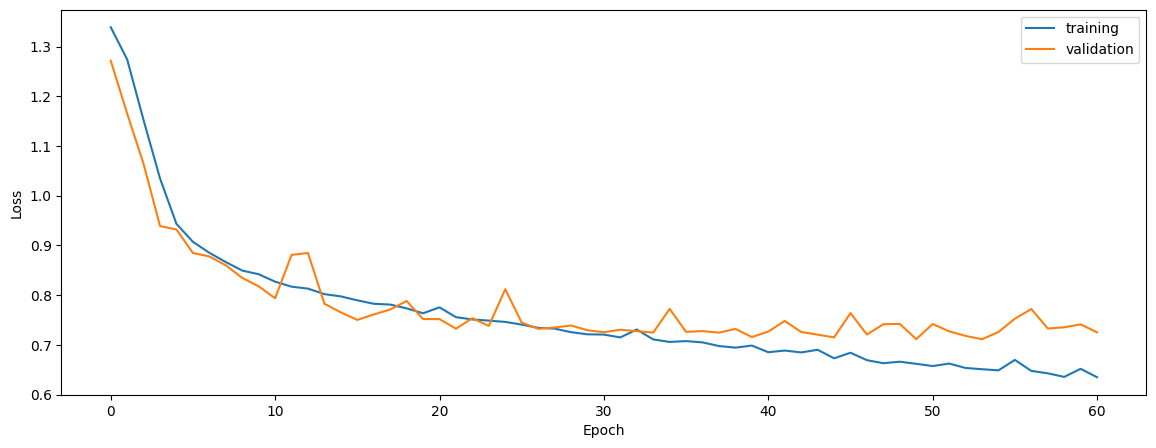

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getAccuracy(train[1],train[4]))
print(getAccuracy(val[1],val[4]))
print(getAccuracy(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getAccuracy(train[1],train[4],train[3][0]))
print(getAccuracy(val[1],val[4],val[3][0]))
print(getAccuracy(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getAccuracy(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getAccuracy(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getAccuracy(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


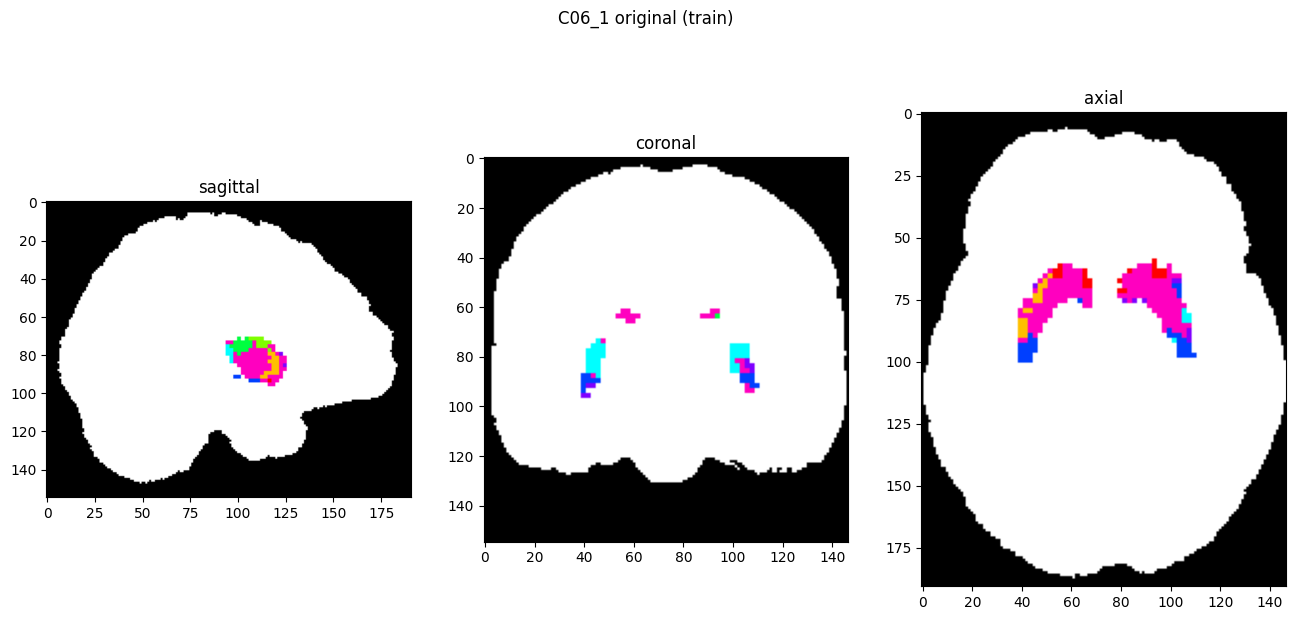

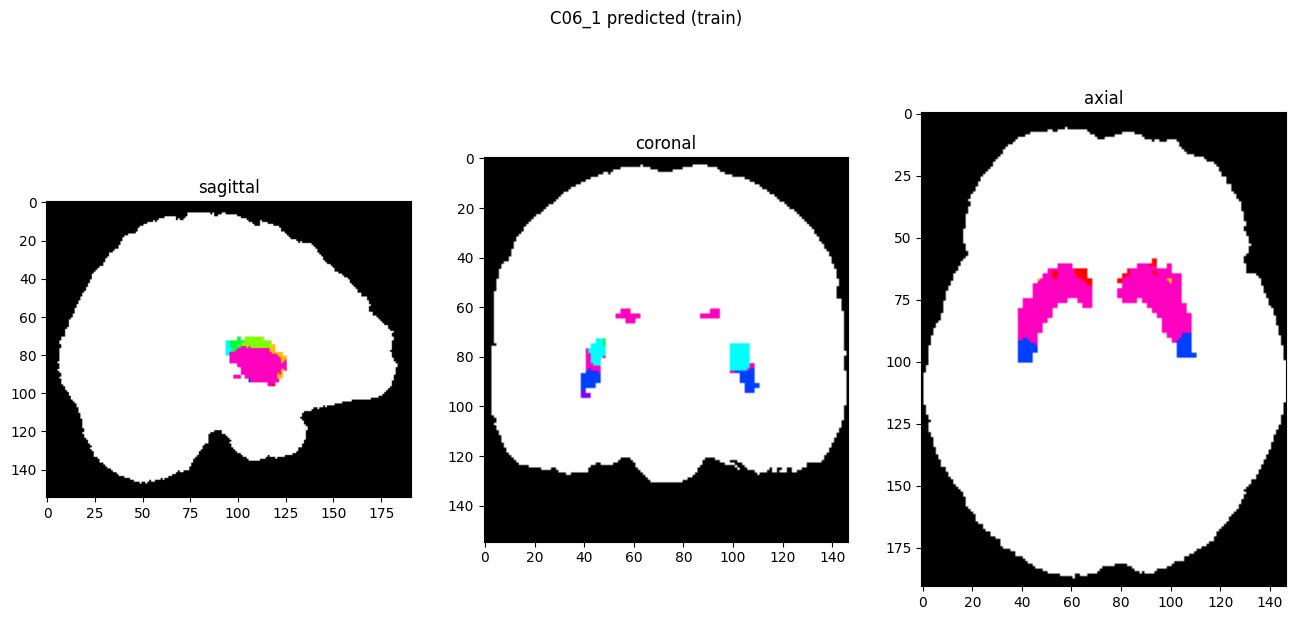

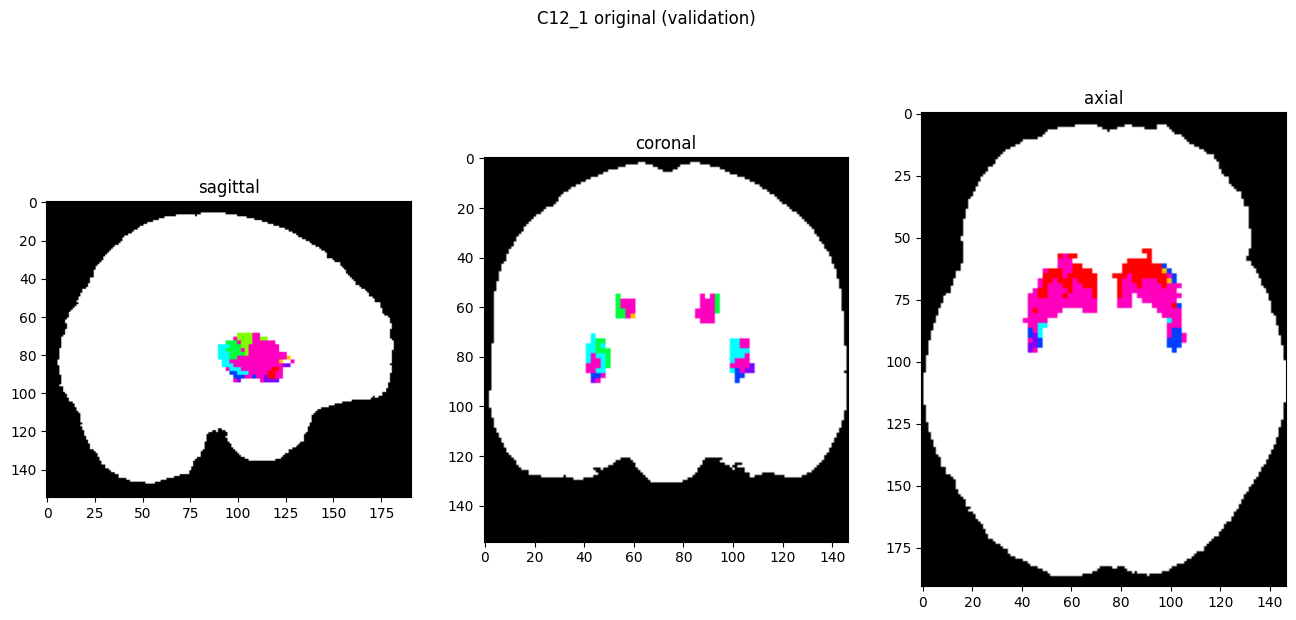

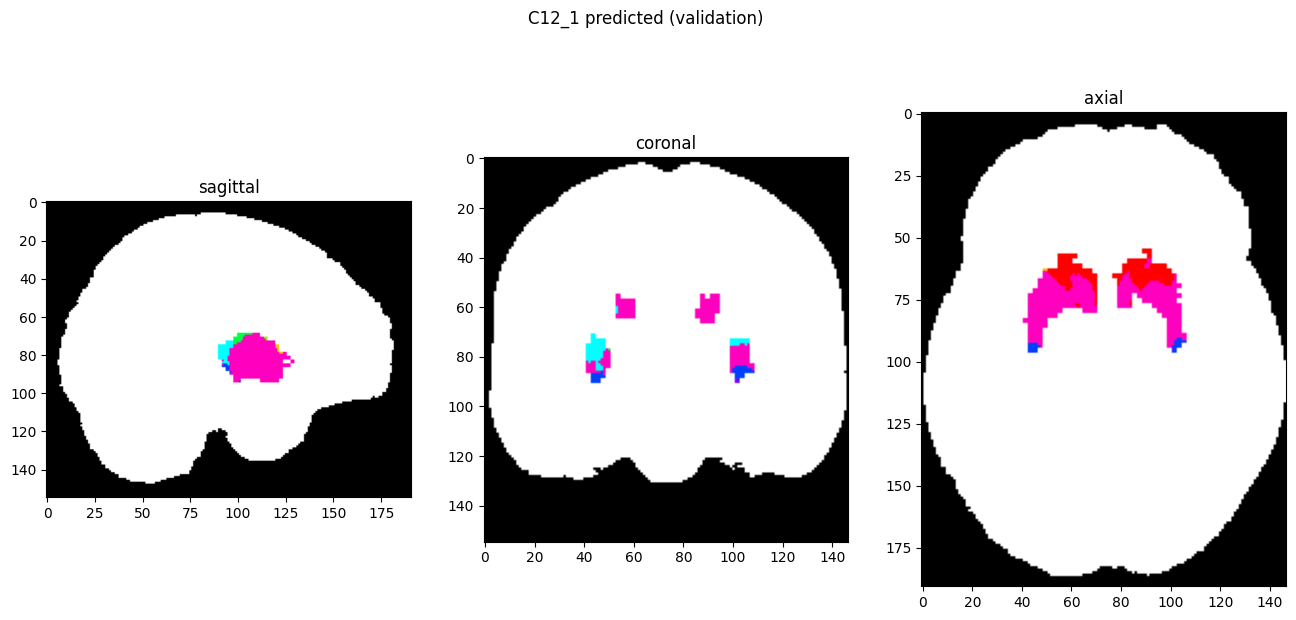

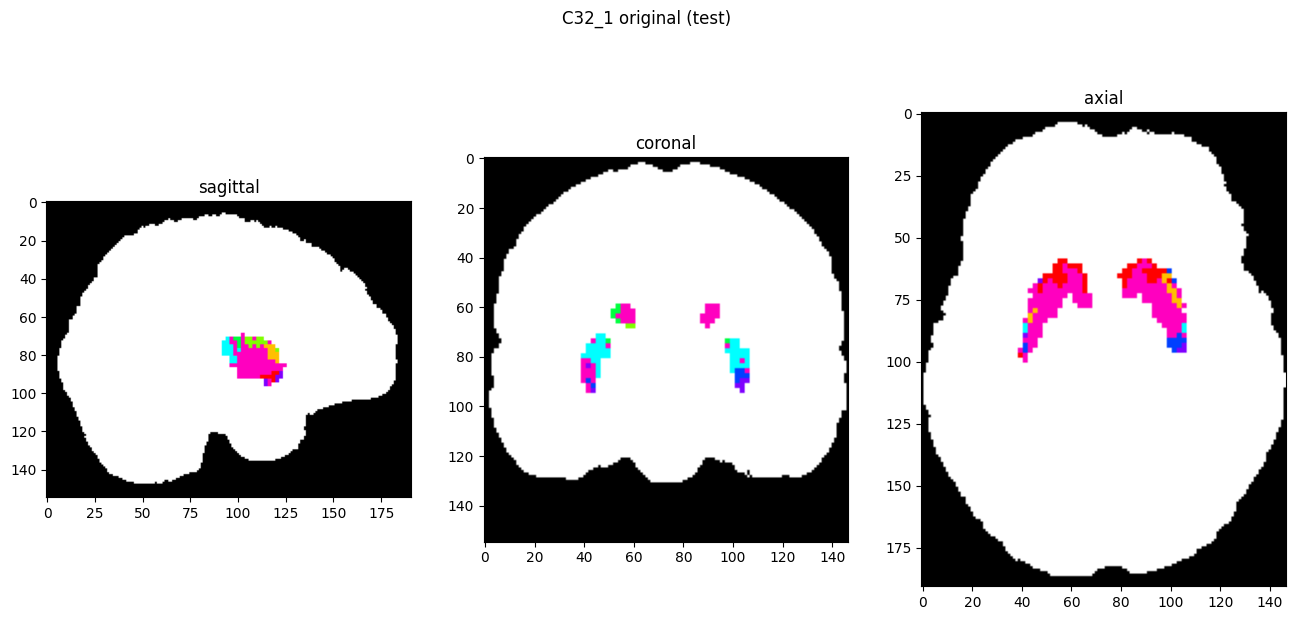

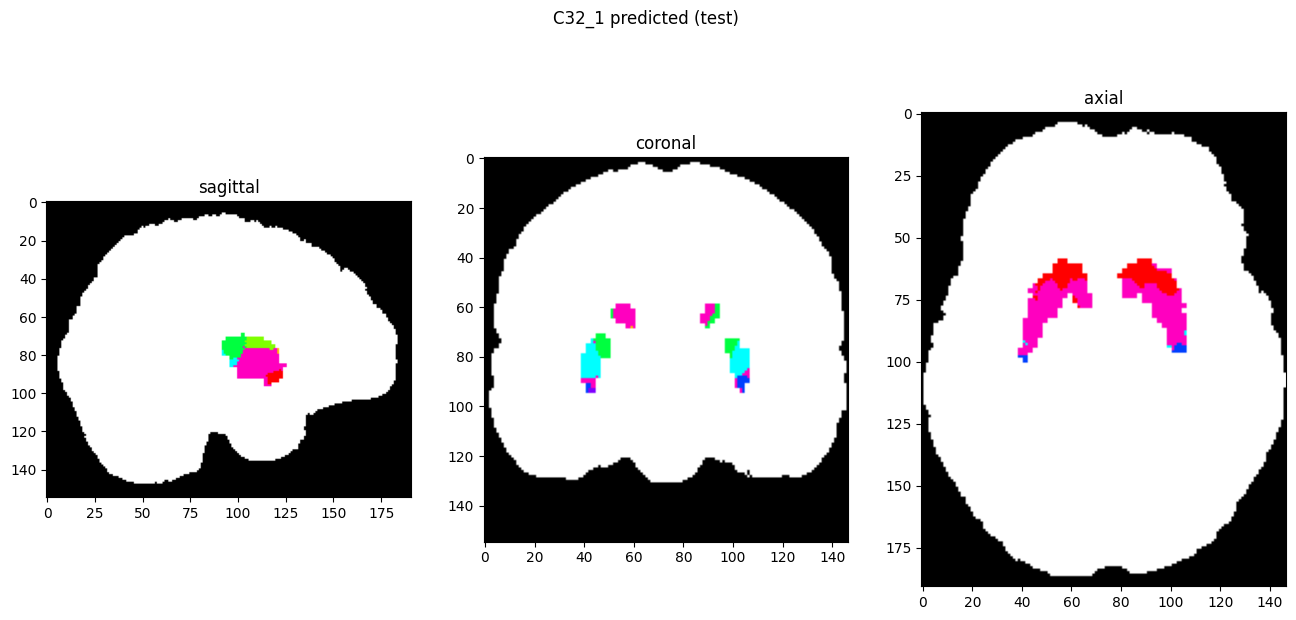

In [10]:
showResults(model, gen, threshold=0)